In [35]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
import cv2
from tqdm import tqdm
from tqdm import tqdm_notebook
import seaborn as sns
from scipy.misc import imread
from PIL import Image
from sklearn.utils import shuffle

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.metrics import confusion_matrix
import itertools

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from tsne import bh_sne

# 1. Image data EDA and quality control

In [2]:
base_dir = '/Volumes/Yuchen_Drive/Chest_xray'
train_path = os.path.join(base_dir, 'train')
val_path = os.path.join(base_dir, 'val')
test_path = os.path.join(base_dir, 'test')

## 1.1 Explore the color mode of X-Ray images

The dataset description doesn't provide information about the image color mode. X-Ray images can be in gray scale. First, I use `scipy.misc.imread` to compute the number of channels for each image

In [5]:
## use 'glob' module to find file paths for images
total_files = glob(os.path.join(base_dir, '*/*/*.jpeg'))
num_multi = 0
img_multi = []
num_gray = 0
for i in tqdm_notebook(np.arange(len(total_files)), '5856 total'):
    img = imread(total_files[i])
    if len(img.shape) < 3:
        num_gray += 1
    else:
        num_multi += 1
        img_multi.append(total_files[i])
print('{}/{} images are in grayscale'.format(num_gray, num_multi+num_gray))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  import sys



5573/5856 images are in grayscale


5573/5856 images only have one color channel and are in gray scale. For the remaining 283 images with multi-channels, I further compared every pixel value in each channel to see whether it is grayscale.

In [6]:
len(img_multi)

283

In [7]:
def gray_scale_check(img_path):
    img = Image.open(img_path).convert('RGB')
    w,h = img.size
    for i in range(w):
        for j in range(h):
            r,g,b = img.getpixel((i,j))
            if (r!=g) or (r!=b) or (g!=b):
                return False
    return True

img_multi_gray = [gray_scale_check(img_path) for img_path in img_multi]

In [8]:
print('{}/{} multi-channel images are in grayscale'.format(sum(img_multi_gray), len(img_multi_gray)))

283/283 multi-channel images are in grayscale


283 out of 283 images with multi-channels have the same pixel values in all channels and are also considered as in grayscale. 

## 1.2 Calculate basic image statistics

Images have been split in training, validation and test datasets. Each dataset has two folders corresponding to two image categories `NORMAL` and `PNEUMONIA`.

In [9]:
train_neg = glob(os.path.join(train_path, 'NORMAL/*.jpeg'))
train_pos = glob(os.path.join(train_path, 'PNEUMONIA/*.jpeg'))
val_neg = glob(os.path.join(val_path, 'NORMAL/*.jpeg'))
val_pos = glob(os.path.join(val_path, 'PNEUMONIA/*.jpeg'))
test_neg = glob(os.path.join(test_path, 'NORMAL/*.jpeg'))
test_pos = glob(os.path.join(test_path, 'PNEUMONIA/*.jpeg'))

Lower-order statistics such as the mean and variance of image pixel intensity can be used to describe texture. To analyze these statistics, the maximum, minimum, 0.1 quantile, 0.9 quantile, mean values and standard deviation of pixel intensity for each image is computed.

In [114]:
def image_summary(image_paths, img_label, img_dataset):
    '''compute and output image_label, image_dataset,  
       maximum, minimum, 0.1 quantile, 0.9 quantile and mean values of pixel intensity,
       height and width for each image'''
    img_dict = {}
    for i in range(len(image_paths)):
        img_path = image_paths[i]
        img_dict[img_path] = {}

        img = cv2.imread(img_path)[:,:,0]
        img_dict[img_path]['label'] = img_label
        img_dict[img_path]['dataset'] = img_dataset
        img_dict[img_path]['max'] = img.max()
        img_dict[img_path]['min'] = img.min()
        
        channel_mean = img.mean()
        channel_std = img.std()
        channel_q01 = np.quantile(img, 0.1)
        channel_q09 = np.quantile(img, 0.9)
        img_dict[img_path]['mean'] = channel_mean
        img_dict[img_path]['std'] = channel_std
        img_dict[img_path]['q01'] = channel_q01
        img_dict[img_path]['q09'] = channel_q09
        
        img_dict[img_path]['height'], img_dict[img_path]['width'] = img.shape[0], img.shape[1]
        
    img_df = pd.DataFrame.from_dict(img_dict, orient = 'index')
    return img_df

In [115]:
train_neg_df = image_summary(train_neg, 'NORMAL', 'train')
train_pos_df = image_summary(train_pos, 'PNEUMONIA', 'train')
val_neg_df = image_summary(val_neg, 'NORMAL', 'val')
val_pos_df = image_summary(val_pos, 'PNEUMONIA', 'val')
test_neg_df = image_summary(test_neg, 'NORMAL', 'test')
test_pos_df = image_summary(test_pos, 'PNEUMONIA', 'test')

In [5]:
pixel_df = pd.concat([train_neg_df, train_pos_df, val_neg_df, val_pos_df, test_neg_df, test_pos_df])
## save the pixel file
# pixel_df.to_csv('Chest_Xray_Grayscale_pixel_df.csv', index_label = 'img_id')
# pixel_df = pd.read_csv('Chest_Xray_Grayscale_pixel_df.csv', index_col = 'img_id')
pixel_df.head()

label dataset  max  min  \
img_id                                                                         
/Volumes/Yuchen_Drive/Chest_xray/train/NORMAL/I...  NORMAL   train  255    0   
/Volumes/Yuchen_Drive/Chest_xray/train/NORMAL/I...  NORMAL   train  255    0   
/Volumes/Yuchen_Drive/Chest_xray/train/NORMAL/I...  NORMAL   train  255    0   
/Volumes/Yuchen_Drive/Chest_xray/train/NORMAL/I...  NORMAL   train  255    0   
/Volumes/Yuchen_Drive/Chest_xray/train/NORMAL/I...  NORMAL   train  255    0   

                                                          mean        std  \
img_id                                                                      
/Volumes/Yuchen_Drive/Chest_xray/train/NORMAL/I...  128.907478  62.301030   
/Volumes/Yuchen_Drive/Chest_xray/train/NORMAL/I...  100.650624  59.808347   
/Volumes/Yuchen_Drive/Chest_xray/train/NORMAL/I...  121.971530  68.856428   
/Volumes/Yuchen_Drive/Chest_xray/train/NORMAL/I...  132.986188  64.970663   
/Volumes/Yuchen_Drive/Chest_xray/train/NORMAL/I...  106.224797  65.088725   

                                                     q01    q09  height  width  
img_id                                                                          
/Volumes/Yuchen_Drive/Chest_xray/train/NORMAL/I...  24.0  205.0    1858   2090  
/Volumes/Yuchen_Drive/Chest_xray/train/NORMAL/I...  11.0  180.0    1152   1422  
/Volumes/Yuchen_Drive/Chest_xray/train/NORMAL/I...   0.0  203.0    1434   1810  
/Volumes/Yuchen_Drive/Chest_xray/train/NORMAL/I...  14.0  204.0    1279   1618  
/Volumes/Yuchen_Drive/Chest_xray/train/NORMAL/I...   0.0  189.0    1125   1600

In [6]:
pixel_df.describe()

max          min         mean          std          q01  \
count  5856.000000  5856.000000  5856.000000  5856.000000  5856.000000   
mean    252.759563     0.212090   122.786271    56.989903    31.081216   
std      10.627402     2.775167    18.391648     9.396742    26.850088   
min     153.000000     0.000000    58.722966    20.415354     0.000000   
25%     255.000000     0.000000   111.616378    50.736895     7.000000   
50%     255.000000     0.000000   122.753346    57.328348    28.000000   
75%     255.000000     0.000000   134.313617    63.696503    49.000000   
max     255.000000    76.000000   221.536623    87.480423   193.000000   

               q09       height        width  
count  5856.000000  5856.000000  5856.000000  
mean    188.401639   970.689037  1327.880806  
std      18.120290   383.392117   363.500922  
min      94.000000   127.000000   384.000000  
25%     179.000000   688.000000  1056.000000  
50%     190.000000   888.000000  1281.000000  
75%     200.000000  1187.000000  1560.000000  
max     248.000000  2713.000000  2916.000000

To check images with all pixel values very low (black)

In [7]:
img_dark = pixel_df[pixel_df['max'] < 30].index
print('Number of dark images: {}'.format(len(img_dark)))

Number of dark images: 0


To check images with all pixel values very high (bright)

In [8]:
img_bright = pixel_df[pixel_df['min'] > 225].index
print('Number of bright images: {}'.format(len(img_bright)))

Number of bright images: 0


There are no extremely dark or bright images. All X-Ray images pass the quality control.

## 1.3 Compare pixel intensity

Text(0.5, 0.98, 'Average pixel intensity for X-Ray images of chest')

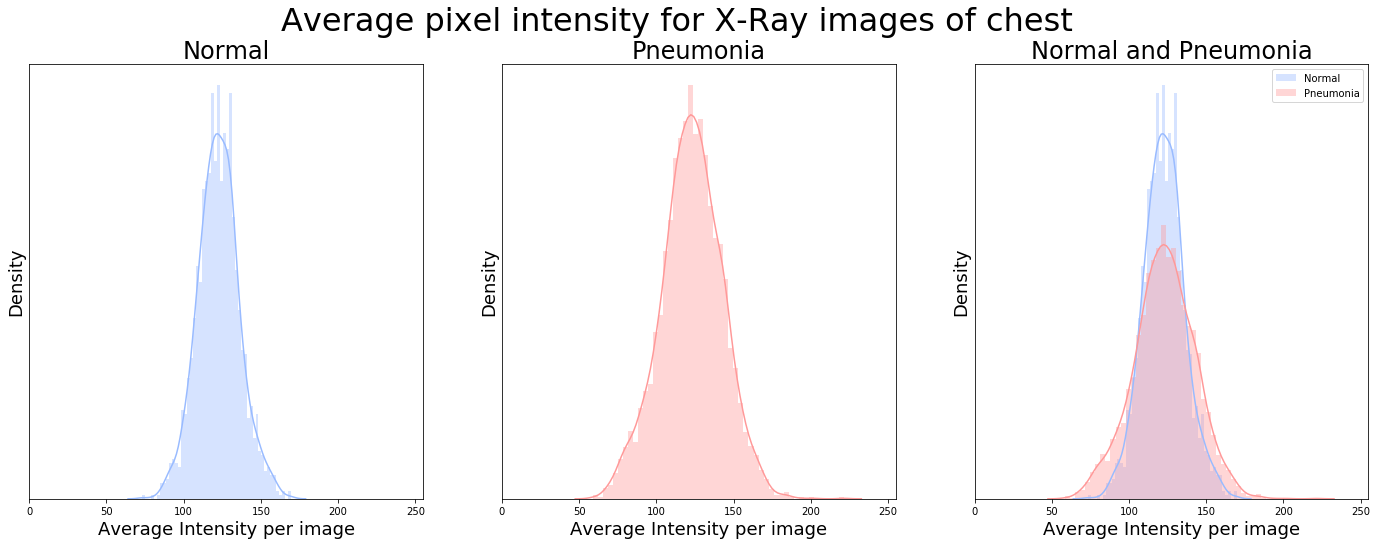

In [15]:
fig, ax = plt.subplots(1,3, figsize=(24,8))
sns.distplot(pixel_df[pixel_df.label=='NORMAL']['mean'], bins=50, color='#99bbff', ax = ax[0])
ax[0].set_title('Normal', fontsize=24)
ax[0].set_xlabel('Average Intensity per image', fontsize=18)
ax[0].set_ylabel('Density', fontsize=18)
ax[0].set_xlim(0,255)
ax[0].set_yticks([])

sns.distplot(pixel_df[pixel_df.label=='PNEUMONIA']['mean'], bins=50, color='#ff9999', ax = ax[1])
ax[1].set_title('Pneumonia', fontsize=24)
ax[1].set_xlabel('Average Intensity per image', fontsize=18)
ax[1].set_ylabel('Density', fontsize=18)
ax[1].set_xlim(0,255)
ax[1].set_yticks([])

sns.distplot(pixel_df[pixel_df.label=='NORMAL']['mean'], bins=50, color='#99bbff', label='Normal', ax = ax[2])
sns.distplot(pixel_df[pixel_df.label=='PNEUMONIA']['mean'], bins=50, color='#ff9999', label = 'Pneumonia', ax = ax[2])
ax[2].set_title('Normal and Pneumonia', fontsize=24)
ax[2].set_xlabel('Average Intensity per image', fontsize=18)
ax[2].set_ylabel('Density', fontsize=18)
ax[2].set_xlim(0,255)
ax[2].set_yticks([])    
ax[2].legend()

fig.suptitle('Average pixel intensity for X-Ray images of chest', fontsize = 32)

Text(0.5, 0.98, 'Standard deviation of pixel intensity for X-Ray images of chest')

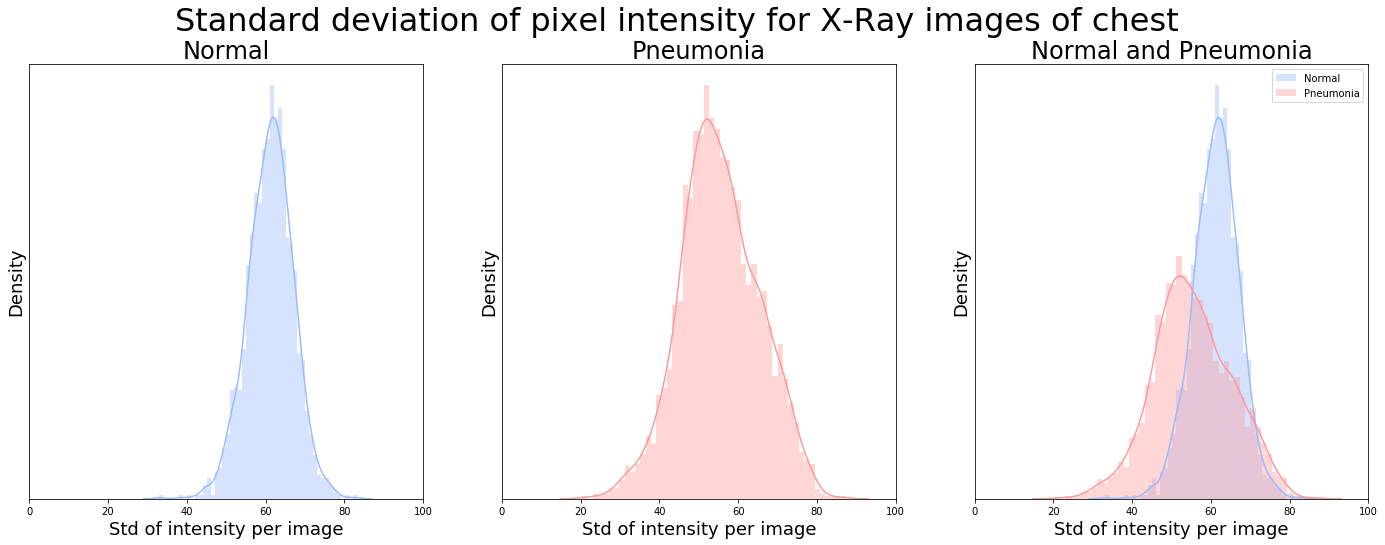

In [121]:
fig, ax = plt.subplots(1,3, figsize=(24,8))
sns.distplot(pixel_df[pixel_df.label=='NORMAL']['std'], bins=50, color='#99bbff', ax = ax[0])
ax[0].set_title('Normal', fontsize=24)
ax[0].set_xlabel('Std of intensity per image', fontsize=18)
ax[0].set_ylabel('Density', fontsize=18)
ax[0].set_xlim(0,100)
ax[0].set_yticks([])

sns.distplot(pixel_df[pixel_df.label=='PNEUMONIA']['std'], bins=50, color='#ff9999', ax = ax[1])
ax[1].set_title('Pneumonia', fontsize=24)
ax[1].set_xlabel('Std of intensity per image', fontsize=18)
ax[1].set_ylabel('Density', fontsize=18)
ax[1].set_xlim(0,100)
ax[1].set_yticks([])

sns.distplot(pixel_df[pixel_df.label=='NORMAL']['std'], bins=50, color='#99bbff', label='Normal', ax = ax[2])
sns.distplot(pixel_df[pixel_df.label=='PNEUMONIA']['std'], bins=50, color='#ff9999', label = 'Pneumonia', ax = ax[2])
ax[2].set_title('Normal and Pneumonia', fontsize=24)
ax[2].set_xlabel('Std of intensity per image', fontsize=18)
ax[2].set_ylabel('Density', fontsize=18)
ax[2].set_xlim(0,100)
ax[2].set_yticks([])    
ax[2].legend()

fig.suptitle('Standard deviation of pixel intensity for X-Ray images of chest', fontsize = 32)

Average pixel intensity for X-Ray images of both `NORMAL` and `PNEUMONIA` categories approximates normal distribution with around the same mean value, but PNEUMONIA images have a larger standard deviation of average intensity compared to NORMAL images. One feature of pneumonia is the appearance of white spots (infiltrates) in the lungs that indicate an infeciton. Patients with pneumonia may also have other complications such as pleural effusions that can be determined based on X-Ray images. Altogether, these indicate that normal lungs have a relatively consistent pixel intensity pattern compared to lungs with pneunomia, which is consistent with the larger variation of average intensity for lungs with pneumonia.

However, the standard deviation of pixel values within a single image is smaller in `PNEUMONIA` class compared to `TUMOR`. One possiblity is that the normal chest has a 'black' appearance which is a big contrast to the bones and heart that have a 'white' appearance. The appearance of infiltrates in the lung will increase the white area (shadow) in the original 'dark' region, and thus make the pixel intensity more homogeneous. 

## 1.4 Visualize images

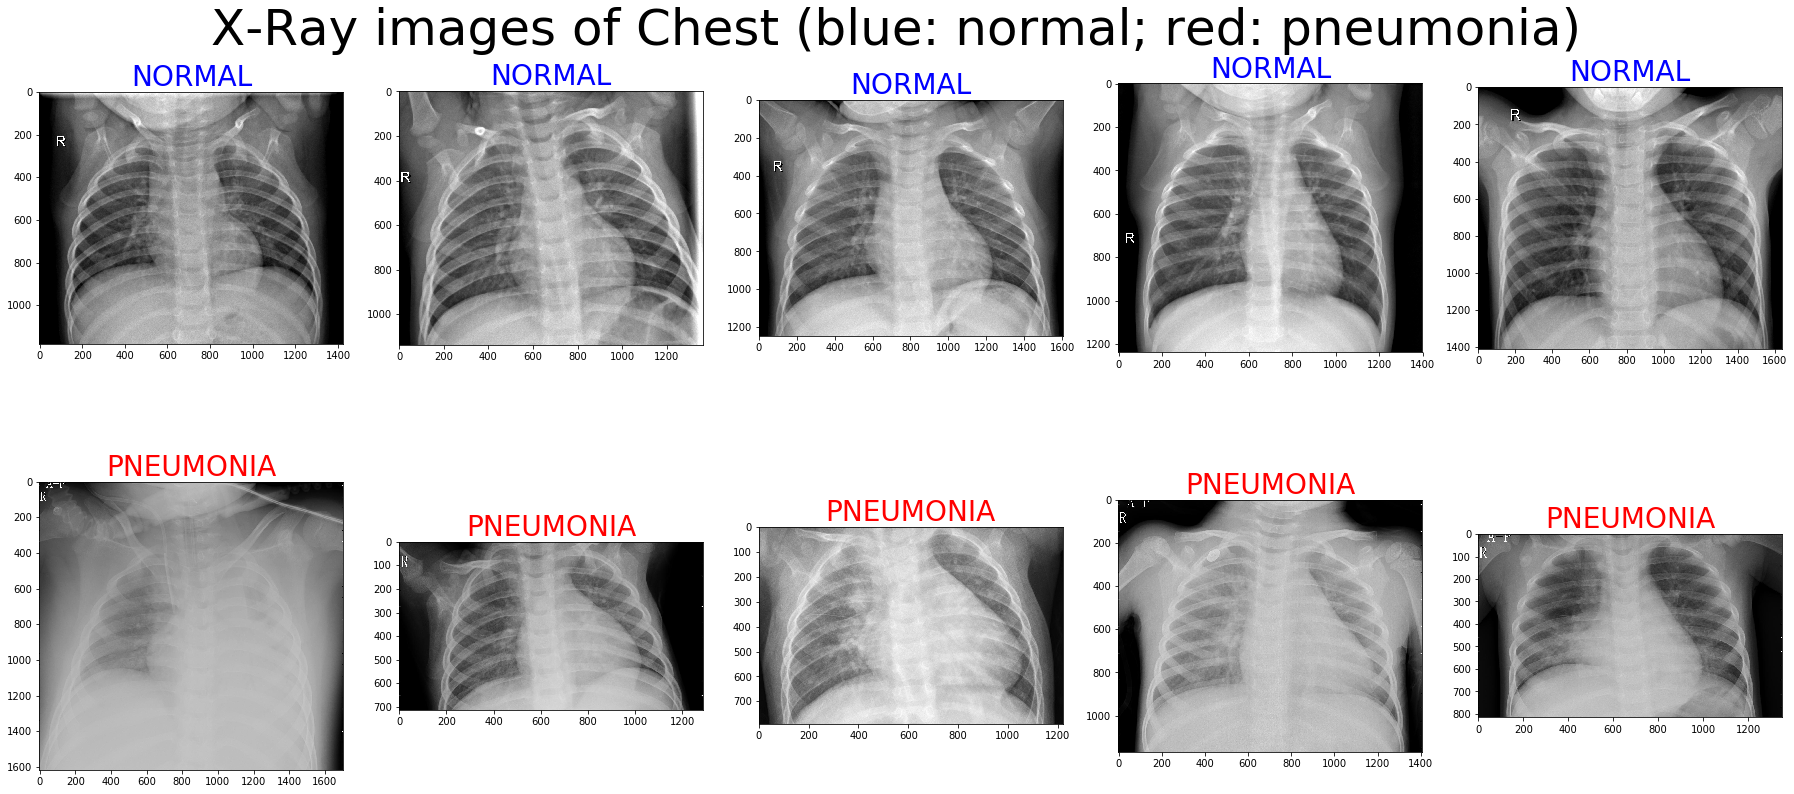

In [16]:
## visualize 5 random images from each class
fig = plt.figure(figsize=(25,12))
for i in np.arange(5):
    plt.subplot(2,5,i+1)
    plt.imshow(cv2.imread(shuffle(train_neg)[i])[:,:,0], cmap = 'gray')
    plt.title('NORMAL', color = 'blue', fontsize=28)
for i in np.arange(5):
    plt.subplot(2,5,i+6)
    plt.imshow(cv2.imread(shuffle(train_pos)[i])[:,:,0], cmap = 'gray')
    plt.title('PNEUMONIA', color = 'red', fontsize=28)
fig.suptitle('X-Ray images of Chest (blue: normal; red: pneumonia)', fontsize=50)
plt.tight_layout()

[]

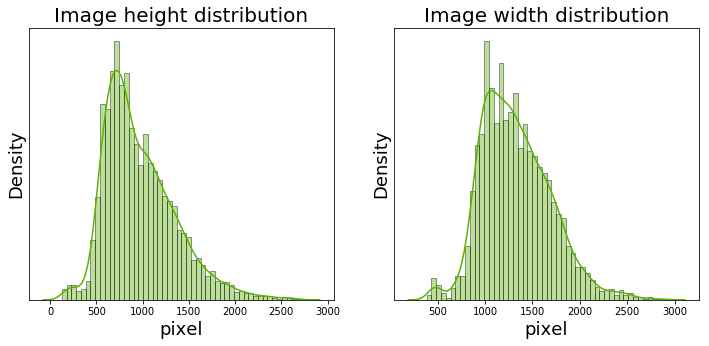

In [122]:
## Check image size distribution
fig, ax = plt.subplots(1,2, figsize=(12,5))
sns.distplot(pixel_df.height, bins=50, hist_kws={'edgecolor':'black'}, color='#59b300', ax = ax[0])
ax[0].set_title('Image height distribution', fontsize=20)
ax[0].set_xlabel('pixel', fontsize=18)
ax[0].set_ylabel('Density', fontsize=18)
ax[0].set_yticks([])

sns.distplot(pixel_df.width, bins=50, hist_kws={'edgecolor':'black'}, color='#59b300', ax = ax[1])
ax[1].set_title('Image width distribution', fontsize=20)
ax[1].set_xlabel('pixel', fontsize=18)
ax[1].set_ylabel('Density', fontsize=18)
ax[1].set_yticks([])

The X-Ray images have variable sizes. In order to be trained in CNN models, images need to be resized to the same value.

## 1.5 Split images in the training dataset to training and validation datasets

In [123]:
train_neg_num = train_neg_df.shape[0]
train_pos_num = train_pos_df.shape[0]
val_neg_num = val_neg_df.shape[0]
val_pos_num = val_pos_df.shape[0]
test_neg_num = test_neg_df.shape[0]
test_pos_num = test_pos_df.shape[0]

print('NORMAL/PNEUMONIA distribution in train_folder: \n{}/{} ({:.2f}%/{:.2f}%)'.format(train_neg_num, train_pos_num, train_neg_num/(train_neg_num+train_pos_num)*100, train_pos_num/(train_neg_num+train_pos_num)*100))
print('NORMAL/PNEUMONIA distribution in val_folder: \n{}/{} ({:.2f}%/{:.2f}%)'.format(val_neg_num, val_pos_num, val_neg_num/(val_neg_num+val_pos_num)*100, val_pos_num/(val_neg_num+val_pos_num)*100))
print('NORMAL/PNEUMONIA distribution in test_folder: \n{}/{} ({:.2f}%/{:.2f}%)'.format(test_neg_num, test_pos_num, test_neg_num/(test_neg_num+test_pos_num)*100, test_pos_num/(test_neg_num+test_pos_num)*100))

NORMAL/PNEUMONIA distribution in train_folder: 
1341/3875 (25.71%/74.29%)
NORMAL/PNEUMONIA distribution in val_folder: 
8/8 (50.00%/50.00%)
NORMAL/PNEUMONIA distribution in test_folder: 
234/390 (37.50%/62.50%)


Text(0.5, 1.0, 'Number of images in each dataset')

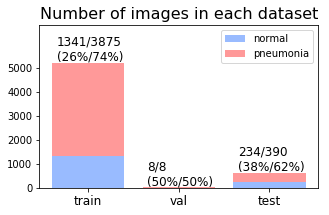

In [45]:
neg_num = (train_neg_num, val_neg_num, test_neg_num)
pos_num = (train_pos_num, val_pos_num, test_pos_num)
width = 0.2
fig = plt.figure(figsize = (5,3))
ax = fig.add_subplot(1,1,1)
p1=plt.bar(np.arange(3), neg_num, color='#99bbff')
p2=plt.bar(np.arange(3), pos_num, bottom=neg_num, color='#ff9999')
plt.xticks(np.arange(3), ('train', 'val', 'test'), size=12)
plt.ylim(0,6800)
plt.yticks(np.arange(0,6000,1000))
plt.legend((p1[0], p2[0]), ('normal', 'pneumonia'))
for i in np.arange(3):
    ax.text(i-0.35, neg_num[i]+pos_num[i]+100, '{}/{}\n({:.0f}%/{:.0f}%)'.format(neg_num[i],pos_num[i],neg_num[i]/(neg_num[i]+pos_num[i])*100,pos_num[i]/(neg_num[i]+pos_num[i])*100), fontsize=12)
plt.title('Number of images in each dataset', fontsize=16)

This is a binary classification problem of X-Ray images with two classes `NORMAL` and `PNEUMONIA`. The number of X-Ray images for NORMAL and PNEUMONIA cases is imbalanced (not 50%/50%) in training and testing dataset. In general, there are more PNEUMONIA images in both training and testing sets. This imbalance is usual for biomedical imaging, but we need to be careful when choosing appropriate metric to evaluate the training model.

The ratio of NORMAL/PNEUMONIA images is not consistent across training/validation/test datasets. The NORMAL/PNEUMONIA ratio is around 1:3 in training dataset, 1:1 in validation dataset, and around 1:1.67 in test dataset. In addition, there are only 16 images in the validation set, which is too small and may lead to significant bias as the trained model overall is in favor of both training and validation sets. Thus, the training data needs to stratified into training and validaiton sets and the ratio of classes should be kept equal in each dataset to achieve consistent prediction performance scores.

# 2. Build CNN from stratch and train images

## 2.1 Image pre-processing and data loading

As discussed above, first I need to generate a new validation set by stratifying the training data into training and validation sets with a train/val ratio of 0.8/0.2 to allocate the samples evenly based on classes to achieve more consistent prediction performance.

Here I used `SubsetRandomSampler` from `torch.utils.data.sampler` to stratify images.

In [16]:
valid_size = 0.2
total_train = train_neg_num+train_pos_num   ## 5216
#total_train=5216
indices = np.arange(total_train)
np.random.seed(123)
np.random.shuffle(indices)
split = int(np.floor(valid_size * total_train))
train_idx, val_idx = indices[split:], indices[:split]

In [17]:
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

Image transformation:

1.Resize: Images don't have a uniform size and need to be resized


2.To prevent overfitting, the following image augmentations will be applied:
   * random rotation

   Augmentation will be applied to both training and validation datasets to perform random modifications to both datasets -- test time augmentation (TTA). During the validation process, the predictions will be based on the augmented images.


3.Normalization: pixel values are normalized to the range [-1, 1]. After normalization, all features will have the same range and contribute equally to the model. In addition, the model will be less sensitive to small changes in weights and easier to be optimized.

In [18]:
train_transforms = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.Resize((256,256)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

In [19]:
## Batch_size: define the numebr of sampels that will be propagated through the network in one iteration and update the weights
BATCH_SIZE = 32
train_data = datasets.ImageFolder(train_path, transform = train_transforms)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, sampler = train_sampler)
val_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, sampler = val_sampler)

Visualize images post augmentation

Text(0.5, 0.98, 'Chest X-Ray images post augmentation')

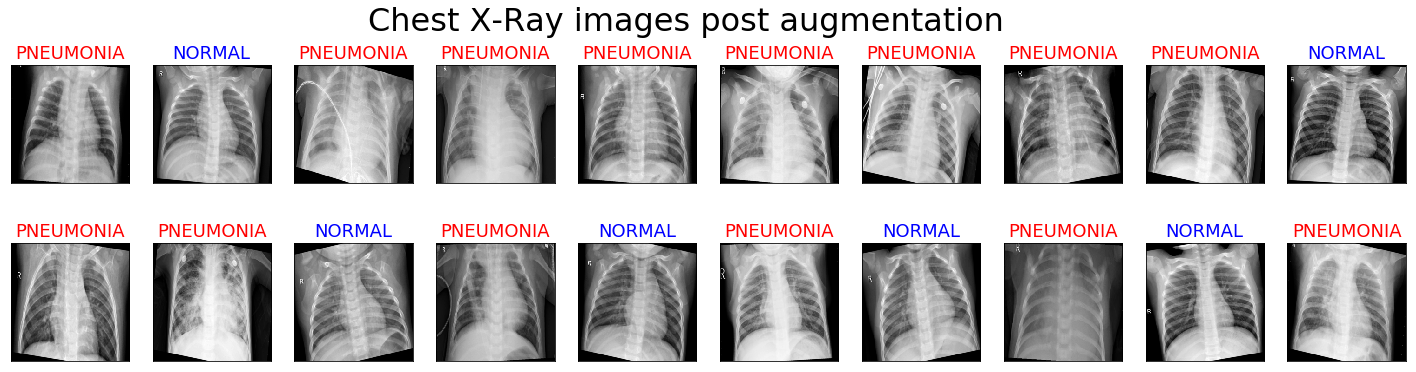

In [128]:
def imshow_transform(img):
    '''visualize images post augmentation'''
    img = img*0.5+0.5
    plt.imshow(img, cmap = 'gray')

images, labels = next(iter(train_loader))
images = images.numpy().squeeze()
classes = train_data.classes
color = ['blue', 'red']

fig = plt.figure(figsize = (25,6))
for idx in np.arange(20):
    ax = fig.add_subplot(2,10,idx+1,xticks=[], yticks=[])
    imshow_transform(images[idx])
    ax.set_title(classes[labels.numpy()[idx]], color = color[labels.numpy()[idx]], fontsize=18)
fig.suptitle('Chest X-Ray images post augmentation', fontsize = 32)

## 2.2 Build CNN model from scratch

Here is the illustration of the CNN network:

**((ConV-ReLU)x3-MaxPool)x3 --flattening-- FC1-ReLU-FC2**

<img src="images/Image1_CNN.tif" width=600px>

`nn.Dropout` is applied following the MaxPooling layer after each stack of convolutional layers as well as the first fully-connected layer to avoid overfitting. `p` is set as `0.3`, which suggests that in each forward pass, each node will be trandomly dropped with a probability of 0.3. 

In [20]:
class Model(nn.Module):
    def __init__(self):
        super(Model,self).__init__()
        self.conv1_1 = nn.Conv2d(1,32,3,padding=1)
        self.conv1_2 = nn.Conv2d(32,32,3,padding=1)
        self.conv1_3 = nn.Conv2d(32,32,3,padding=1)

        self.conv2_1 = nn.Conv2d(32,64,3,padding=1)
        self.conv2_2 = nn.Conv2d(64,64,3,padding=1)
        self.conv2_3 = nn.Conv2d(64,64,3,padding=1)

        self.conv3_1 = nn.Conv2d(64,128,3,padding=1)
        self.conv3_2 = nn.Conv2d(128,128,3,padding=1)
        self.conv3_3 = nn.Conv2d(128,128,3,padding=1)

        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(128*32*32,256)
        self.fc2 = nn.Linear(256,2)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = F.relu(self.conv1_1(x))
        x = F.relu(self.conv1_2(x))
        x = F.relu(self.conv1_3(x))
        x = self.pool(x)
        x = self.dropout(x)

        x = F.relu(self.conv2_1(x))
        x = F.relu(self.conv2_2(x))
        x = F.relu(self.conv2_3(x))
        x = self.pool(x)
        x = self.dropout(x)

        x = F.relu(self.conv3_1(x))
        x = F.relu(self.conv3_2(x))
        x = F.relu(self.conv3_3(x))
        x = self.pool(x)
        x = self.dropout(x)

        x = x.view(-1,128*32*32)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)

        return x

## 2.3 Train CNN model

'GPU' can significantly speed up the training process compared to 'CPU'. For this project, I trained the CNN model using GPU in cluster.

In [21]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device: {}'.format(device.type))

device: cpu


In [22]:
model = Model()
# specify loss function
criterion = nn.CrossEntropyLoss()
# specify optimizer
optimizer = optim.Adam(model.parameters(), lr=0.00001)

In order to prevent overfitting, the following `train` function has both training and validation phases. The function trains images in the training dataset for the specified epochs (one epoch: one cycle through the full training dataset) and after each epoch, runs a full validation step. After each epoch, output of the loss function as well as the prediction accuracy is computed for both training and validation datasets, saved as `train_loss`, `train_acc`, `val_loss` and `val_acc`.

Although the training process will go through the specified number of epochs `n_epochs`, the model with the lowest `val_loss` will be saved. The reason to go through the specified epochs is to understand how the `train_loss`, `train_acc`, `val_loss` and `val_acc` values change following each epoch to help fine-tune hyperparameters to improve the training performance. In routine training jobs, the `Early Stopping` approach can be taken instead so that model training will stop when the specified evaluation metric (eg. accuracy) on the validation set decreases or doesn't improve within a certain number of epochs.

In [23]:
def train(n_epochs, train_loader, val_loader, model, criterion, optimizer, device, save_path):
    '''the train function will perform both forward and backpropagation on training and validation datasets.
    Output: trained model with the lowest val_loss and dataframe containing train_loss/train_acc and val_loss/val_acc for each epoch'''
    epoch_dict={}
    valid_loss_min = np.Inf
    model = model.to(device)
    for epoch in np.arange(n_epochs):
        # Initiate loss and accuracy values
        train_loss = 0.0
        train_acc = 0.0
        val_loss = 0.0
        val_acc = 0.0
        epoch_dict[epoch] = {}
        # Training
        model.train()
        for images, labels in train_loader:
            optimizer.zero_grad()
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            ## Update loss and acc values for the training process
            train_loss += loss.item()*images.shape[0]
            _, top_class = output.topk(1,dim=1)
            equals = top_class == labels.view(*top_class.shape)
            train_acc += torch.mean(equals.type(torch.FloatTensor)).item()

        # Validation
        else:
            # turn off gradients
            with torch.no_grad():
                # set model to evaluation mode
                model.eval()
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    output = model(images)
                    loss = criterion(output, labels)
                    ## Update loss and acc values for the validation process
                    val_loss += loss.item()*images.shape[0]
                    _, top_class = output.topk(1,dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    val_acc += torch.mean(equals.type(torch.FloatTensor)).item()

                ### write training/validation loss/accuracy
                epoch_dict[epoch]['Train_Loss'] = train_loss/len(train_loader.sampler)
                epoch_dict[epoch]['Train_Accuracy'] = train_acc/len(train_loader)
                epoch_dict[epoch]['Val_Loss'] = val_loss/len(val_loader.sampler)
                epoch_dict[epoch]['Val_Accuracy'] = val_acc/len(val_loader)

                print("Epoch: {}/{}.. ".format(epoch+1, n_epochs),
                      "Train Loss: {:.3f}.. ".format(train_loss/len(train_loader.sampler)),
                      "Train Accuracy: {:.3f}.. ".format(train_acc/len(train_loader)),
                      "Validation Loss: {:.3f}.. ".format(val_loss/len(val_loader.sampler)),
                      "Validation Accuracy: {:.3f}".format(val_acc/len(val_loader)))
                
                ## save the model with the lowest val_loss and update valid_loss_min
                if val_loss <= valid_loss_min:
                    print('Validation loss decreased -- Saving model -- \n')
                    torch.save(model.state_dict(), save_path)
                    valid_loss_min = val_loss

    epoch_df = pd.DataFrame.from_dict(epoch_dict, orient = 'index')
    epoch_df['Epoch'] = np.arange(n_epochs)+1
    return model, epoch_df

In [ ]:
n_epochs = 50
save_path = 'models/Chest_xray_PyTorch_model1_epoch50_lr5_fc256.pth'
model, epoch_df = train(n_epochs, train_loader, val_loader, model, criterion, optimizer, device, save_path)

Training was performed in cluster, and here I will load the training statistics as well as the trained model for model evaluation.

## 2.4 Visualize the loss and accuracy curves

In [24]:
epoch_df = pd.read_csv('models/Chest_xray_PyTorch_model1_epoch50_lr5_fc256.csv')

Text(0.5, 1.0, 'Training and Validation Accuracy')

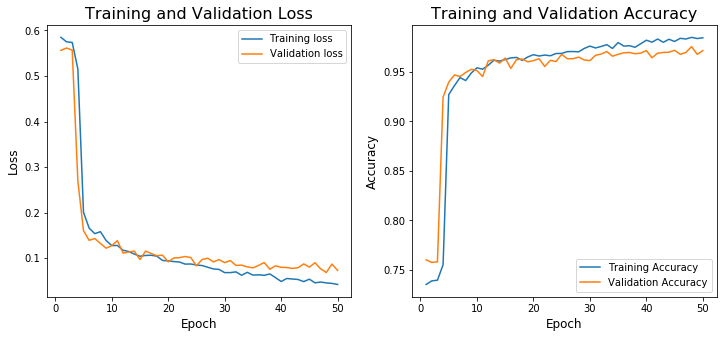

In [25]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epoch_df.Epoch, epoch_df.Train_Loss, label = 'Training loss')
plt.plot(epoch_df.Epoch, epoch_df.Val_Loss, label = 'Validation loss')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.title('Training and Validation Loss', fontsize=16)

plt.subplot(1,2,2)
plt.plot(epoch_df.Epoch, epoch_df.Train_Accuracy, label = 'Training Accuracy')
plt.plot(epoch_df.Epoch, epoch_df.Val_Accuracy, label = 'Validation Accuracy')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()
plt.title('Training and Validation Accuracy', fontsize=16)

## 2.5 Load the trained model

In [26]:
model = Model()
if device.type == 'cpu':
    state_dict = torch.load('models/Chest_xray_PyTorch_model1_epoch50_lr5_fc256.pth', map_location='cpu')
else:
    state_dict = torch.load('models/Chest_xray_PyTorch_model1_epoch50_lr5_fc256.pth')
model.load_state_dict(state_dict)
for param in model.parameters():
    param.requires_grad=False

## 2.6 Load images from test dataset

In addition to calculating the overall prediction accuracy of the test dataset, it's also important to know which images are classified correctly or incorrectly as well as prediction probability for future improvement and better interpretation of the classification results. 

Here, I use a modified `torchvision.datasets.ImageFolder` to load images with their path info.

reference: https://gist.github.com/andrewjong/6b02ff237533b3b2c554701fb53d5c4d

In [27]:
class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [28]:
## No augmentation
test_transforms = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])
test_data = ImageFolderWithPaths(test_path, transform = test_transforms)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = BATCH_SIZE, shuffle = True)

## 2.7 Make prediction on test dataset

In [29]:
def model_eval(test_loader, model, criterion, device, classes):
    '''Apply the trained model to testing dataset and summarize the overall test_loss/test_acc
    also output testing accuracy for each category and the prediction result for each sample as well as the probability'''
    # Initiate loss and accuracy values
    test_loss = 0.0
    test_acc = 0.0
    class_correct = list(0. for i in range(len(classes)))
    class_total = list(0. for i in range(len(classes)))
  
    dt = np.dtype(int)
    true_label = np.array([], dtype = dt)
    pred_label = np.array([], dtype = dt)
    path_array = np.array([])
    prob_array = np.array([])
    probs_array = np.array(classes).reshape(1,-1)
    
    model = model.to(device)
    with torch.no_grad():
        model.eval()
        for images, labels, paths in test_loader:
            path_array = np.append(path_array, np.array(paths))
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            loss = criterion(output, labels)
            test_loss += loss.item()*images.shape[0]
        
            softmax = nn.Softmax(dim=1)
            output_softmax = softmax(output)
            top_probs, preds = output_softmax.topk(1,dim=1)
            equals = preds == labels.view(*preds.shape)
            correct = np.squeeze(equals)
            test_acc += torch.mean(equals.type(torch.FloatTensor)).item()
            for i in range(len(images)):
                label = labels[i].item()
                class_correct[label] += correct[i].item()
                class_total[label] += 1
    
            if device.type == 'cpu':
                true_label = np.append(true_label, labels)
                pred_label = np.append(pred_label, preds)
                prob_array = np.append(prob_array, top_probs)
                probs_array = np.concatenate((probs_array, output_softmax))
      
            else:
                true_label = np.append(true_label, labels.cpu())
                pred_label = np.append(pred_label, preds.cpu())
                prob_array = np.append(prob_array, top_probs.cpu())
                probs_array = np.concatenate((probs_array, output_softmax.cpu()))
            
      
    test_loss = test_loss/len(test_loader.sampler)
    test_acc = test_acc/len(test_loader)
    print('Test Loss: {:.6f}\n'.format(test_loss))
    print('Test Accuracy (Overall): {:.3f}%  ({}/{})\n'.format(np.sum(class_correct)/np.sum(class_total)*100, np.sum(class_correct), np.sum(class_total)))
  
    for i in range(len(classes)):
        if class_total[i] > 0:
            print('Test Accuracy of {}: {:.3f}% ({}/{})'.format(classes[i], class_correct[i]/class_total[i]*100,class_correct[i], class_total[i]))
        else:
            print('Test Accuracy of {}: N/A'.format(classes[i]))
    summary_df = pd.DataFrame({'category': classes, 'correct': class_correct, 'total': class_total})
    pred_df = pd.DataFrame({'file_path': path_array, 'true_label': true_label, 'prediction': pred_label, 'prob': prob_array})
    probs_df = pd.DataFrame(probs_array[1:], columns = probs_array[0])
    probs_df['file_path'] = path_array
    pred_df = pred_df.merge(probs_df, left_on = 'file_path', right_on = 'file_path')
    return summary_df, pred_df

In [30]:
criterion = nn.CrossEntropyLoss()
classes = test_data.classes
summary_df, pred_df = model_eval(test_loader, model, criterion, device, classes)

Test Loss: 1.585901

Test Accuracy (Overall): 75.160%  (469.0/624.0)

Test Accuracy of NORMAL: 35.470% (83.0/234.0)
Test Accuracy of PNEUMONIA: 98.974% (386.0/390.0)


In [227]:
# summary_df.to_csv('models/Chest_xray_PyTorch_model1_epoch50_lr5_fc256_summary_df.csv', index = False)
# pred_df.to_csv('models/Chest_xray_PyTorch_model1_epoch50_lr5_fc256_pred_df.csv', index = False)

## 2.8 Evaluate model performance

Since this dataset is imbalanced, accuracy is not a good evaluation metric to assess the model performance. Alternative metrics include:
* **Precision**: True Positives / (True Positives + False Positives)

* **Recall (sensitivity)**: True Positives / (True Positives + False Negatives)

* **F1**: 2 * (precision * recall) / (precision + recall)
* **ROC** (described later)

Precision describes how good a model is at predicting the positive class. Recall describes how good the model is at predicting the positive class when the actual outcome is positive. The goal is to try to improve both precision and recall scores. However, there is often an inverse relationship between these two metrics that one score increases at the cost of reducing the other. 

F1 score is a weighted average of the precision and recall to provide a single measurement for a system. F1 score is in the range of [0,1] and a higher F1 score means better model performance.

### 2.8.1 Confusion matrix

In [31]:
cm1 = confusion_matrix(pred_df.true_label, pred_df.prediction)

In [100]:
def plot_confusion_matrix(cm, classes,title='Confusion matrix',cmap=plt.cm.Blues):    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=12)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, '{:d} \n({:.2f}%)'.format(cm[i, j], cm[i,j]/cm.sum()*100), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

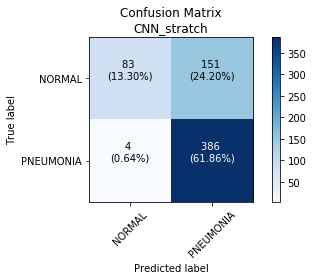

In [101]:
plot_confusion_matrix(cm1, classes, title = 'Confusion Matrix\nCNN_stratch')

### 2.8.2 Compute precision, recall, F1 scores

In [34]:
precision = precision_score(pred_df.true_label, pred_df.prediction)
recall = recall_score(pred_df.true_label, pred_df.prediction)
f1 = f1_score(pred_df.true_label, pred_df.prediction)
print('precision: {:.3f}'.format(precision))
print('recall: {:.3f}'.format(recall))
print('f1 score: {:.3f}'.format(f1))

precision: 0.719
recall: 0.990
f1 score: 0.833


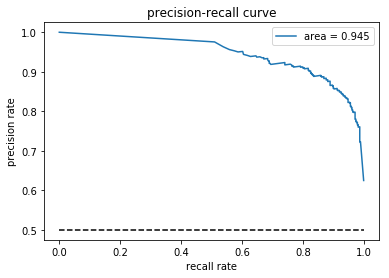

In [35]:
precision, recall, thresholds = precision_recall_curve(pred_df.true_label, pred_df.prob*pred_df.prediction)
# calculate precision-recall AUC
auc_score = auc(recall, precision)

plt.figure(1)
plt.plot([0, 1], [0.5, 0.5], 'k--')
plt.plot(recall, precision, label='area = {:.3f}'.format(auc_score))
plt.xlabel('recall rate')
plt.ylabel('precision rate')
plt.title('precision-recall curve')
plt.legend(loc='best')
plt.show()

### 2.8.3 ROC

**ROC** (Receiver Operating Characteristic) curve is a plot of TPR versus FPR for a number of different threshold values between 0.0 and 1.0.

**TPR** (Recall): True Positive Rate = True Positives / (True Positives + False Negatives)

**FPR**: False Positive Rate = False Positives / (False Positives + True Negatives)

FPR describes how often a positive class is predicted when the actual outcome is negative

**AUC**: area under the ROC curve, as a measure of aggregated classification performance

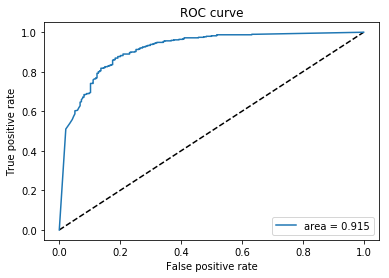

In [36]:
from sklearn.metrics import roc_curve, auc
## probs: probabilities for class 1 only
fpr, tpr, thresholds = roc_curve(pred_df.true_label, pred_df.prob*pred_df.prediction)
auc_value = auc(fpr, tpr)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='area = {:.3f}'.format(auc_value))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

### Short summary of choosing evaluation metrics and understanding prediction results:
There is no gold standard / 'best' rule of choosing a single metric to evaluate a binary classification model. It's often important to compute scores for multiple metrics to have a more comprehensive understanding of the prediction performance. Another factor we need to consider is in real-world application, the risk of having 'false positives' and 'false negatives' for a specific classification problem. It's important to achieve an optimal balance between recall and precision to optimize the overall classification model.

As we can see above, prediction accuracy for PNEUMONIA is very good 98.974% (only 4 cases are misclassified). However, the accuracy of NORMAL images is really bad. This is refected by a low precision of 0.719 and good recall rate of 0.990, with a very high false positive rate. The major defect of this type of misclassification is that more than half of the people with no pneunomia will be classified as 'PNEUMONIA'. However, for patients who do have pneumonia, they have more than 98% probability of being sucessfully diagnosed by this trained model. 

The low precision / high recall rate may be due to the unbalanced dataset. For imbalanced dataset, the model is often trained in a way to improve the prediction accuracy of the class that carries more weight while ignore the classification accuracy of other minority classes. If this hypothesis is true, to improve the precision and decrease false positive rate, one simple solution is to assign weights to each of the class.

## 2.9 Add weight to the loss function and repeat step `2.3-2.8`

In [37]:
model_w = Model()
# specify loss function and class_weight
class_weight = [3,1]
class_weight = torch.FloatTensor(class_weight)
class_weight = class_weight.to(device)
criterion_w = nn.CrossEntropyLoss(weight = class_weight)
# specify optimizer
optimizer = optim.Adam(model_w.parameters(), lr=0.00001)

In [ ]:
n_epochs = 50
save_path = 'models/Chest_xray_PyTorch_model1_epoch50_lr5_weight_fc256.pth'
model_w, epoch_df_w = train(n_epochs, train_loader, val_loader, model_w, criterion_w, optimizer, device, save_path)

In [39]:
epoch_df_w = pd.read_csv('models/Chest_xray_PyTorch_model1_epoch50_lr5_weight_fc256.csv')

Text(0.5, 1.0, 'Training and Validation Accuracy')

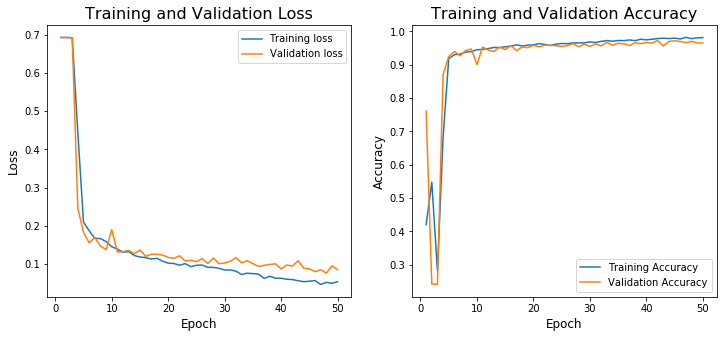

In [40]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epoch_df_w.Epoch, epoch_df_w.Train_Loss, label = 'Training loss')
plt.plot(epoch_df_w.Epoch, epoch_df_w.Val_Loss, label = 'Validation loss')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.title('Training and Validation Loss', fontsize=16)

plt.subplot(1,2,2)
plt.plot(epoch_df_w.Epoch, epoch_df_w.Train_Accuracy, label = 'Training Accuracy')
plt.plot(epoch_df_w.Epoch, epoch_df_w.Val_Accuracy, label = 'Validation Accuracy')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()
plt.title('Training and Validation Accuracy', fontsize=16)

In [41]:
model_w = Model()
if device.type == 'cpu':
    state_dict = torch.load('models/Chest_xray_PyTorch_model1_epoch50_lr5_weight_fc256.pth', map_location='cpu')
else:
    state_dict = torch.load('models/Chest_xray_PyTorch_model1_epoch50_lr5_weight_fc256.pth')
model_w.load_state_dict(state_dict)
for param in model_w.parameters():
    param.requires_grad=False

In [42]:
criterion = nn.CrossEntropyLoss()
classes = test_data.classes
summary_df_w, pred_df_w = model_eval(test_loader, model_w, criterion, device, classes)

Test Loss: 0.945434

Test Accuracy (Overall): 80.609%  (503.0/624.0)

Test Accuracy of NORMAL: 51.282% (120.0/234.0)
Test Accuracy of PNEUMONIA: 98.205% (383.0/390.0)


In [243]:
# summary_df_w.to_csv('models/Chest_xray_PyTorch_model1_epoch50_lr5_weight_fc256_summary_df.csv', index = False)
# pred_df_w.to_csv('models/Chest_xray_PyTorch_model1_epoch50_lr5_weight_fc256_pred_df.csv', index = False)

In [43]:
cm1_w = confusion_matrix(pred_df_w.true_label, pred_df_w.prediction)

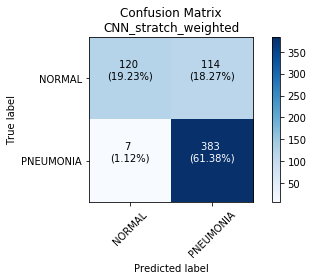

In [102]:
plot_confusion_matrix(cm1_w, classes, title = 'Confusion Matrix\nCNN_stratch_weighted')

In [45]:
precision = precision_score(pred_df_w.true_label, pred_df_w.prediction)
recall = recall_score(pred_df_w.true_label, pred_df_w.prediction)
f1 = f1_score(pred_df_w.true_label, pred_df_w.prediction)
print('precision: {:.3f}'.format(precision))
print('recall: {:.3f}'.format(recall))
print('f1 score: {:.3f}'.format(f1))

precision: 0.771
recall: 0.982
f1 score: 0.864


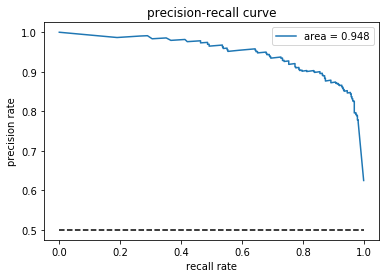

In [46]:
precision, recall, thresholds = precision_recall_curve(pred_df_w.true_label, pred_df_w.prob*pred_df_w.prediction)
# calculate precision-recall AUC
auc_score = auc(recall, precision)

plt.figure(1)
plt.plot([0, 1], [0.5, 0.5], 'k--')
plt.plot(recall, precision, label='area = {:.3f}'.format(auc_score))
plt.xlabel('recall rate')
plt.ylabel('precision rate')
plt.title('precision-recall curve')
plt.legend(loc='best')
plt.show()

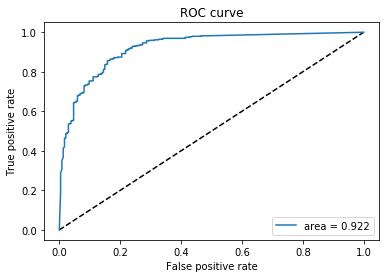

In [47]:
from sklearn.metrics import roc_curve, auc
## probs: probabilities for class 1 only
fpr, tpr, thresholds = roc_curve(pred_df_w.true_label, pred_df_w.prob*pred_df_w.prediction)
auc_value = auc(fpr, tpr)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='area = {:.3f}'.format(auc_value))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

Adding class_weight to loss function does slightly increase precision score from 0.719 to 0.771. As a tradeoff, there is a slight decrease in recall from 0.990 to 0.982. The overall F1 score increases from 0.833 to 0.864 and the number of false positives decreases from 151 to 114. Although there is no significant improvement in this CNN model, the direction is still promising and provides insight into how to further improve this model which will be discussed in the end of this notebook. 

# 3. Transfer Learning -- InceptionV3

The classification performance of the CNN network build-from-scratch is suboptimal. One possible reason is the small size of the dataset we have for this study as only 5216 images are included. One approach to overcoming the limitation of small dataset is to employ `Transfer Learning` to use a ConvNet pretrained on a very large dataset (e.g. ImageNet). The final fully-connected layer (classifier) of the pretrained model will be replaced with the new classifier with output that fits our dataset, and the rest of the ConvNet will be treated as a fixed feature extractor. During training, only the final linear classifier is trained on top of the fixed feature extractor for the new dataset. 

Here, I use [Inception-v3](https://arxiv.org/pdf/1512.00567.pdf), a 42 layer deep network that uses inception modules as building blocks.

<img src="images/Image2_InceptionV3_Architecture.png" width=600px>

(Figure adapted from [ref2](https://medium.com/@sh.tsang/review-inception-v3-1st-runner-up-image-classification-in-ilsvrc-2015-17915421f77c))

There are several points that we need to pay attention when using `Inception-v3` model:
   * **Auxiliary Classifier**: Inception-v3 has auxiliary classifier and the overall loss is caculated based on both auxiliary output and the final output. Thus, in addition to replacing the final classifier, the auxiliary classifier also needs to be replaced. The `train` function will be updated in the step of loss calculation as `train_aux` function.
   
   * **Input size**: Different from the other pretrained models that expect an input size of (224, 224), `Inception_v3` requires the input size to be (299,299). 

reference: 
1. https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Szegedy_Rethinking_the_Inception_CVPR_2016_paper.pdf
2. https://medium.com/@sh.tsang/review-inception-v3-1st-runner-up-image-classification-in-ilsvrc-2015-17915421f77c
3. http://cs231n.github.io/transfer-learning/
4. https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
5. https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958

## 3.1 Load Inception_v3 pretrained model and replace classifiers

In [48]:
inception = models.inception_v3(pretrained=True)
print(inception.AuxLogits.fc)
print(inception.fc)
for param in inception.parameters():
    param.requires_grad = False

Linear(in_features=768, out_features=1000, bias=True)
Linear(in_features=2048, out_features=1000, bias=True)


In [49]:
## auxiliary classifier
inception.AuxLogits.fc = nn.Sequential(nn.Linear(inception.AuxLogits.fc.in_features, 2))
## final classifier
inception.fc = nn.Sequential(nn.Linear(inception.fc.in_features, 2))

## 3.2 Load images and apply image transformation

In [50]:
train_transforms = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.Resize((299,299)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [51]:
train_data = datasets.ImageFolder(train_path, transform = train_transforms)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, sampler = train_sampler)
val_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, sampler = val_sampler)

## 3.3 Train Inception_v3 model (classifiers)

As introduced above, modificaitons are added to the previous `train` function to add computation for the auxiliary output and loss in the training phase as `train_aux`.

In [52]:
def train_aux(n_epochs, train_loader, val_loader, model, criterion, optimizer, device, save_path):
    '''train function specific for Inception_V3 to calcualte auxiliary output'''
    epoch_dict={}
    valid_loss_min = np.Inf
    model = model.to(device)
    for epoch in np.arange(n_epochs):
        # Initiate loss and accuracy values
        train_loss = 0.0
        train_acc = 0.0
        val_loss = 0.0
        val_acc = 0.0
        epoch_dict[epoch] = {}
        # Training
        model.train()
        for images, labels in train_loader:
            optimizer.zero_grad()
            images, labels = images.to(device), labels.to(device)
            # both final output and auxiliary output
            output, aux_output = model(images)
            loss1 = criterion(output, labels)
            loss2 = criterion(aux_output, labels)
            loss = loss1+0.4*loss2
            loss.backward()
            optimizer.step()
            ## Update loss and acc values for the training process
            train_loss += loss.item()*images.shape[0]
            _, top_class = output.topk(1,dim=1)
            equals = top_class == labels.view(*top_class.shape)
            train_acc += torch.mean(equals.type(torch.FloatTensor)).item()

        # Validation
        else:
            with torch.no_grad():
                model.eval()
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    output = model(images)
                    loss = criterion(output, labels)
                    ## Update loss and acc values for the validation process
                    val_loss += loss.item()*images.shape[0]
                    _, top_class = output.topk(1,dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    val_acc += torch.mean(equals.type(torch.FloatTensor)).item()

                ### write training/validation loss/accuracy
                epoch_dict[epoch]['Train_Loss'] = train_loss/len(train_loader.sampler)
                epoch_dict[epoch]['Train_Accuracy'] = train_acc/len(train_loader)
                epoch_dict[epoch]['Val_Loss'] = val_loss/len(val_loader.sampler)
                epoch_dict[epoch]['Val_Accuracy'] = val_acc/len(val_loader)

                print("Epoch: {}/{}.. ".format(epoch+1, n_epochs),
                      "Train Loss: {:.3f}.. ".format(train_loss/len(train_loader.sampler)),
                      "Train Accuracy: {:.3f}.. ".format(train_acc/len(train_loader)),
                      "Validation Loss: {:.3f}.. ".format(val_loss/len(val_loader.sampler)),
                      "Validation Accuracy: {:.3f}".format(val_acc/len(val_loader)))
                if val_loss <= valid_loss_min:
                    print('\n Validation loss decreased -- Saving model -- \n')
                    torch.save(model.state_dict(), save_path)
                    valid_loss_min = val_loss

    epoch_df = pd.DataFrame.from_dict(epoch_dict, orient = 'index')
    epoch_df['Epoch'] = np.arange(n_epochs)+1
    return model, epoch_df

In [53]:
## Parameters from both the final classifier and the auxiliary classifier need to be trained
params = [inception.fc.parameters(), inception.AuxLogits.fc.parameters()]
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(itertools.chain(*params), lr=0.0001)

In [ ]:
n_epochs = 20
save_path = 'models/Chest_xray_PyTorch_inception_epoch20_lr4_fc1.pth'
inception, epoch_df = train_aux(n_epochs, train_loader, val_loader, inception, criterion, optimizer, device, save_path)

## 3.4 Evaluate model performance

In [54]:
epoch_df = pd.read_csv('models/Chest_xray_PyTorch_inception_epoch20_lr4_fc1.csv')

Text(0.5, 1.0, 'Training and Validation Accuracy')

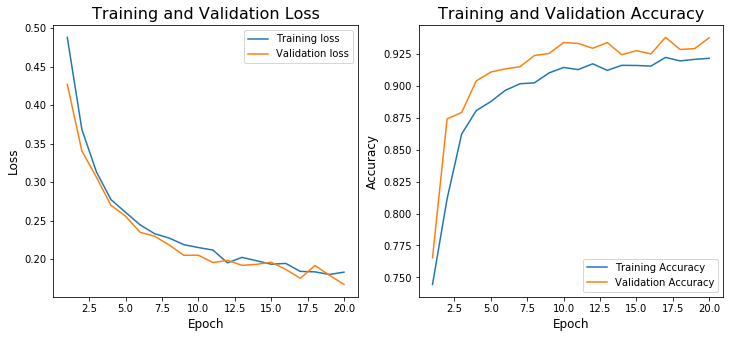

In [55]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epoch_df.Epoch, epoch_df.Train_Loss/1.4, label = 'Training loss')
plt.plot(epoch_df.Epoch, epoch_df.Val_Loss, label = 'Validation loss')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.title('Training and Validation Loss', fontsize=16)

plt.subplot(1,2,2)
plt.plot(epoch_df.Epoch, epoch_df.Train_Accuracy, label = 'Training Accuracy')
plt.plot(epoch_df.Epoch, epoch_df.Val_Accuracy, label = 'Validation Accuracy')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()
plt.title('Training and Validation Accuracy', fontsize=16)

In [56]:
inception = models.inception_v3(pretrained=True)
inception.AuxLogits.fc = nn.Sequential(nn.Linear(inception.AuxLogits.fc.in_features, 2))
inception.fc = nn.Sequential(nn.Linear(inception.fc.in_features, 2))
if device.type == 'cpu':
    state_dict = torch.load('models/Chest_xray_PyTorch_inception_epoch20_lr4_fc1.pth', map_location='cpu')
else:
    state_dict = torch.load('models/Chest_xray_PyTorch_inception_epoch20_lr4_fc1.pth')
inception.load_state_dict(state_dict)
for param in inception.parameters():
    param.requires_grad=False

In [57]:
test_transforms = transforms.Compose([
    transforms.Resize((299,299)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [58]:
test_data = ImageFolderWithPaths(test_path, transform = test_transforms)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = BATCH_SIZE, shuffle = True)

In [59]:
criterion = nn.CrossEntropyLoss()
summary_df, pred_df = model_eval(test_loader, inception, criterion, device, classes)

Test Loss: 0.354004

Test Accuracy (Overall): 83.814%  (523.0/624.0)

Test Accuracy of NORMAL: 67.094% (157.0/234.0)
Test Accuracy of PNEUMONIA: 93.846% (366.0/390.0)


In [141]:
# summary_df.to_csv('models/Chest_xray_PyTorch_inception_epoch20_lr4_fc1_summary_df.csv', index = False)
# pred_df.to_csv('models/Chest_xray_PyTorch_inception_epoch20_lr4_fc1_pred_df.csv', index = False)

### Confusion matrix

In [60]:
cm2 = confusion_matrix(pred_df.true_label, pred_df.prediction)

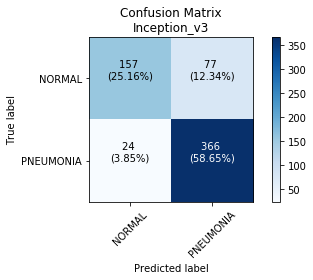

In [103]:
plot_confusion_matrix(cm2, classes, title = 'Confusion Matrix\nInception_v3')

In [62]:
precision = precision_score(pred_df.true_label, pred_df.prediction)
recall = recall_score(pred_df.true_label, pred_df.prediction)
f1 = f1_score(pred_df.true_label, pred_df.prediction)
print('precision: {:.3f}'.format(precision))
print('recall: {:.3f}'.format(recall))
print('f1 score: {:.3f}'.format(f1))

precision: 0.826
recall: 0.938
f1 score: 0.879


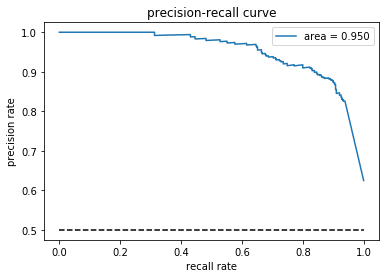

In [63]:
precision, recall, thresholds = precision_recall_curve(pred_df.true_label, pred_df.prob*pred_df.prediction)
# calculate precision-recall AUC
auc_score = auc(recall, precision)

plt.figure(1)
plt.plot([0, 1], [0.5, 0.5], 'k--')
plt.plot(recall, precision, label='area = {:.3f}'.format(auc_score))
plt.xlabel('recall rate')
plt.ylabel('precision rate')
plt.title('precision-recall curve')
plt.legend(loc='best')
plt.show()

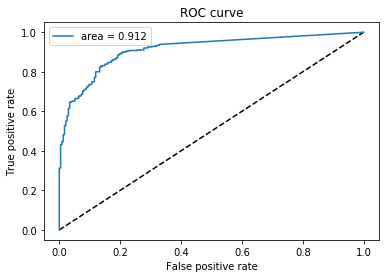

In [64]:
from sklearn.metrics import roc_curve, auc
## probs: probabilities for class 1 only
fpr, tpr, thresholds = roc_curve(pred_df.true_label, pred_df.prob*pred_df.prediction)
auc_value = auc(fpr, tpr)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='area = {:.3f}'.format(auc_value))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

Overall, the prediction performance largely improves using Inception_v3 model. The number of false positive cases decreases to 77, much lower than the 151/114 cases predicted from the scratch CNN model. Prediction accuracy for the `NORMAL` class significantly improves as well as the precision score. However, as discussed before, the prediction accuracy for the `PNEUMONIA` class and recall decreases inversely.

## 3.5 Add weight to the loss function

Recall score is still higher than precision and inspired by adding class_weight to improve precision score in the scratch CNN model, class weight will be added to the Inception_v3 model.

### Training

In [65]:
inception_w = models.inception_v3(pretrained=True)
for param in inception_w.parameters():
    param.requires_grad = False
inception_w.AuxLogits.fc = nn.Sequential(nn.Linear(inception_w.AuxLogits.fc.in_features, 2))
inception_w.fc = nn.Sequential(nn.Linear(inception_w.fc.in_features, 2))

In [66]:
## Parameters from both the final classifier and the auxiliary classifier need to be trained
params = [inception_w.fc.parameters(), inception_w.AuxLogits.fc.parameters()]
# specify loss function and class_weight
class_weight = [3,1]
class_weight = torch.FloatTensor(class_weight)
class_weight = class_weight.to(device)

criterion_w = nn.CrossEntropyLoss(weight = class_weight)
optimizer = optim.Adam(itertools.chain(*params), lr=0.0001)

In [ ]:
n_epochs = 20
save_path = 'models/Chest_xray_PyTorch_inception_epoch20_lr4_weight_fc1.pth'
inception_w, epoch_df = train_aux(n_epochs, train_loader, val_loader, inception_w, criterion_w, optimizer, device, save_path)

### Model evaluation

In [67]:
epoch_df_w = pd.read_csv('models/Chest_xray_PyTorch_inception_epoch20_lr4_weight_fc1.csv')

Text(0.5, 1.0, 'Training and Validation Accuracy')

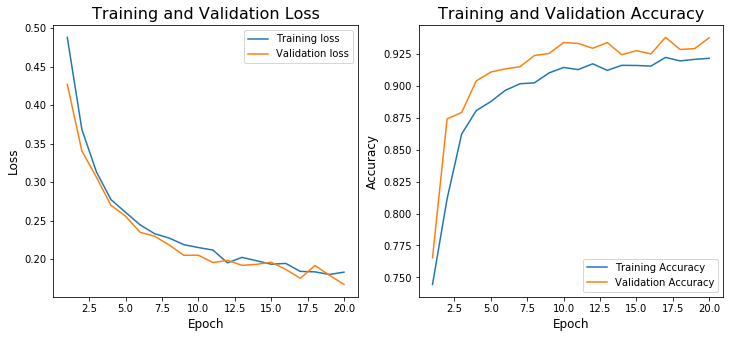

In [68]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epoch_df.Epoch, epoch_df.Train_Loss/1.4, label = 'Training loss')
plt.plot(epoch_df.Epoch, epoch_df.Val_Loss, label = 'Validation loss')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.title('Training and Validation Loss', fontsize=16)

plt.subplot(1,2,2)
plt.plot(epoch_df.Epoch, epoch_df.Train_Accuracy, label = 'Training Accuracy')
plt.plot(epoch_df.Epoch, epoch_df.Val_Accuracy, label = 'Validation Accuracy')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()
plt.title('Training and Validation Accuracy', fontsize=16)

In [69]:
inception_w = models.inception_v3(pretrained=True)
inception_w.AuxLogits.fc = nn.Sequential(nn.Linear(inception_w.AuxLogits.fc.in_features, 2))
inception_w.fc = nn.Sequential(nn.Linear(inception_w.fc.in_features, 2))
if device.type == 'cpu':
    state_dict = torch.load('models/Chest_xray_PyTorch_inception_epoch20_lr4_weight_fc1.pth', map_location='cpu')
else:
    state_dict = torch.load('models/Chest_xray_PyTorch_inception_epoch20_lr4_weight_fc1.pth')
inception_w.load_state_dict(state_dict)
for param in inception_w.parameters():
    param.requires_grad=False

In [70]:
criterion = nn.CrossEntropyLoss()
summary_df_w, pred_df_w = model_eval(test_loader, inception_w, criterion, device, classes)

Test Loss: 0.363677

Test Accuracy (Overall): 83.974%  (524.0/624.0)

Test Accuracy of NORMAL: 85.470% (200.0/234.0)
Test Accuracy of PNEUMONIA: 83.077% (324.0/390.0)


In [153]:
# summary_df_w.to_csv('models/Chest_xray_PyTorch_inception_epoch20_lr4_weight_fc1_summary_df.csv', index = False)
# pred_df_w.to_csv('models/Chest_xray_PyTorch_inception_epoch20_lr4_weight_fc1_pred_df.csv', index = False)

In [71]:
cm2_w = confusion_matrix(pred_df_w.true_label, pred_df_w.prediction)

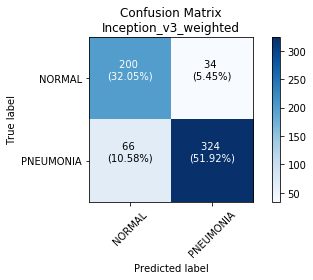

In [104]:
plot_confusion_matrix(cm2_w, classes, title = 'Confusion Matrix\nInception_v3_weighted')

In [73]:
precision = 324/(324+34)
recall = 324/(324+66)
f1 = f1_score(pred_df_w.true_label, pred_df_w.prediction)
print('precision: {:.3f}'.format(precision))
print('recall: {:.3f}'.format(recall))
print('f1 score: {:.3f}'.format(f1))

precision: 0.905
recall: 0.831
f1 score: 0.866


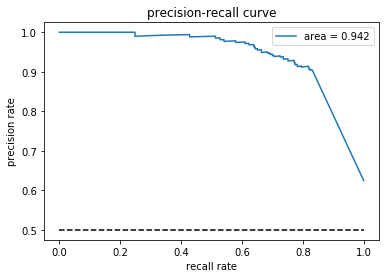

In [74]:
precision, recall, thresholds = precision_recall_curve(pred_df_w.true_label, pred_df_w.prob*pred_df_w.prediction)
# calculate precision-recall AUC
auc_score = auc(recall, precision)

plt.figure(1)
plt.plot([0, 1], [0.5, 0.5], 'k--')
plt.plot(recall, precision, label='area = {:.3f}'.format(auc_score))
plt.xlabel('recall rate')
plt.ylabel('precision rate')
plt.title('precision-recall curve')
plt.legend(loc='best')
plt.show()

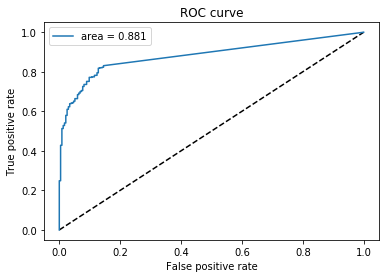

In [75]:
from sklearn.metrics import roc_curve, auc
## probs: probabilities for class 1 only
fpr, tpr, thresholds = roc_curve(pred_df_w.true_label, pred_df_w.prob*pred_df_w.prediction)
auc_value = auc(fpr, tpr)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='area = {:.3f}'.format(auc_value))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

Although precision score significant improves by adding class_weight to the training model, the recall score sacrifices too much and is even lower than the precision score. There is a dramatic increase in the number of false negative cases and one major outcome is that patients with pneumonia cannot be diagnosed, which can lead to very bad consequences. Thus, it is not a good idea to add class_weight to the Inception_v3 model. 

## 3.6 Add another fully-connected layer before the classifer of Inception_v3

It's possible that training only the final classifier is not sufficient to make good prediction on the X-Ray dataset. In order to better fit the Inception_v3 model to the training dataset, another fully-connected layer with 256 nodes is added before the final classifer. 

In [76]:
inception_fc2 = models.inception_v3(pretrained=True)
for param in inception_fc2.parameters():
    param.requires_grad = False
inception_fc2.fc = nn.Sequential(nn.Linear(inception_fc2.fc.in_features, 256),
                             nn.ReLU(),
                             nn.Dropout(0.3),
                             nn.Linear(256, 8))
inception_fc2.AuxLogits.fc = nn.Sequential(nn.Linear(inception_fc2.AuxLogits.fc.in_features, 256),
                                       nn.ReLU(),
                                       nn.Dropout(0.3),
                                       nn.Linear(256, 8))

In [77]:
## Parameters from both the final classifier and the auxiliary classifier need to be trained
params = [inception_fc2.fc.parameters(), inception_fc2.AuxLogits.fc.parameters()]
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(itertools.chain(*params), lr=0.0001)

In [ ]:
n_epochs = 20
save_path = 'models/Chest_xray_PyTorch_inception_epoch20_lr4_fc2.pth'
inception_fc2, epoch_df = train_aux(n_epochs, train_loader, val_loader, inception_fc2, criterion, optimizer, device, save_path)

In [78]:
epoch_df = pd.read_csv('models/Chest_xray_PyTorch_inception_epoch20_lr4_fc2.csv')

Text(0.5, 1.0, 'Training and Validation Accuracy')

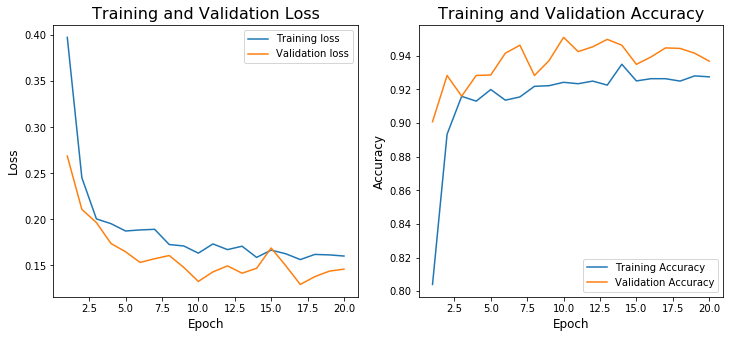

In [79]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epoch_df.Epoch, epoch_df.Train_Loss/1.4, label = 'Training loss')
plt.plot(epoch_df.Epoch, epoch_df.Val_Loss, label = 'Validation loss')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.title('Training and Validation Loss', fontsize=16)

plt.subplot(1,2,2)
plt.plot(epoch_df.Epoch, epoch_df.Train_Accuracy, label = 'Training Accuracy')
plt.plot(epoch_df.Epoch, epoch_df.Val_Accuracy, label = 'Validation Accuracy')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()
plt.title('Training and Validation Accuracy', fontsize=16)

In [80]:
inception_fc2 = models.inception_v3(pretrained=True)
inception_fc2.fc = nn.Sequential(nn.Linear(inception_fc2.fc.in_features, 256),
                             nn.ReLU(),
                             nn.Dropout(0.3),
                             nn.Linear(256, 2))
inception_fc2.AuxLogits.fc = nn.Sequential(nn.Linear(inception_fc2.AuxLogits.fc.in_features, 256),
                                       nn.ReLU(),
                                       nn.Dropout(0.3),
                                       nn.Linear(256, 2))

if device.type == 'cpu':
    state_dict = torch.load('models/Chest_xray_PyTorch_inception_epoch20_lr4_fc2.pth', map_location='cpu')
else:
    state_dict = torch.load('models/Chest_xray_PyTorch_inception_epoch20_lr4_fc2.pth')
inception_fc2.load_state_dict(state_dict)
for param in inception_fc2.parameters():
    param.requires_grad=False

In [81]:
criterion = nn.CrossEntropyLoss()
summary_df, pred_df = model_eval(test_loader, inception_fc2, criterion, device, classes)

Test Loss: 0.308081

Test Accuracy (Overall): 87.660%  (547.0/624.0)

Test Accuracy of NORMAL: 76.923% (180.0/234.0)
Test Accuracy of PNEUMONIA: 94.103% (367.0/390.0)


In [176]:
# summary_df.to_csv('models/Chest_xray_PyTorch_inception_epoch20_lr4_fc2_summary_df.csv', index = False)
# pred_df.to_csv('models/Chest_xray_PyTorch_inception_epoch20_lr4_fc2_pred_df.csv', index = False)

In [82]:
cm3 = confusion_matrix(pred_df.true_label, pred_df.prediction)

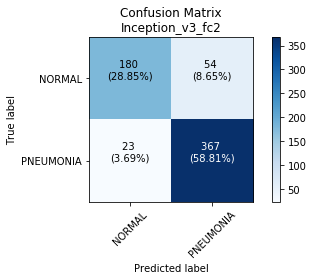

In [105]:
plot_confusion_matrix(cm3, classes, title = 'Confusion Matrix\nInception_v3_fc2')

In [84]:
precision = precision_score(pred_df.true_label, pred_df.prediction)
recall = recall_score(pred_df.true_label, pred_df.prediction)
f1 = f1_score(pred_df.true_label, pred_df.prediction)
print('precision: {:.3f}'.format(precision))
print('recall: {:.3f}'.format(recall))
print('f1 score: {:.3f}'.format(f1))

precision: 0.872
recall: 0.941
f1 score: 0.905


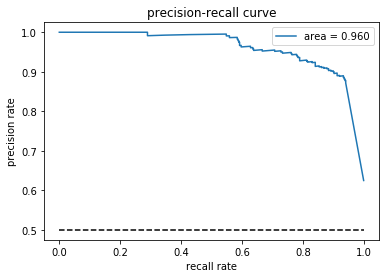

In [85]:
precision, recall, thresholds = precision_recall_curve(pred_df.true_label, pred_df.prob*pred_df.prediction)
# calculate precision-recall AUC
auc_score = auc(recall, precision)

plt.figure(1)
plt.plot([0, 1], [0.5, 0.5], 'k--')
plt.plot(recall, precision, label='area = {:.3f}'.format(auc_score))
plt.xlabel('recall rate')
plt.ylabel('precision rate')
plt.title('precision-recall curve')
plt.legend(loc='best')
plt.show()

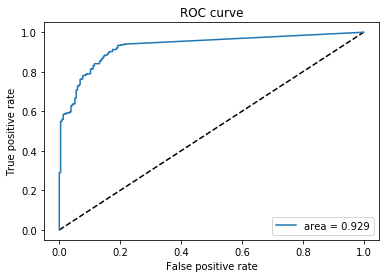

In [86]:
from sklearn.metrics import roc_curve, auc
## probs: probabilities for class 1 only
fpr, tpr, thresholds = roc_curve(pred_df.true_label, pred_df.prob*pred_df.prediction)
auc_value = auc(fpr, tpr)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='area = {:.3f}'.format(auc_value))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

Adding another fully-connected layer to the Inception_v3 model significantly increases all the evaluation metrics (inception_v3 -> **Inception_v3_fc2**):
   * Overall accuracy: 0.838 -> **0.877**
   * Accuracy for NORMAL class: 0.671 -> **0.769**
   * Accuracy for PNEUMONIA class: 0.938 -> **0.941**
   * Precision: 0.826 -> **0.872**
   * Recall: 0.938 -> **0.941**
   * F1 score: 0.879 -> **0.905**
   * ROC_AUC: 0.912 -> **0.929**
   
Although it can be anticipated that adding class weight on top of the new Inception_v3_fc2 model may increase precision in sacrifice of recall based on the previous experience, I still perform the analysis.

## 3.7 Add another fully-connected layer before the classifer and apply class weight

In [87]:
inception_fc2_w = models.inception_v3(pretrained=True)
for param in inception_fc2_w.parameters():
    param.requires_grad = False
inception_fc2_w.fc = nn.Sequential(nn.Linear(inception_fc2_w.fc.in_features, 256),
                             nn.ReLU(),
                             nn.Dropout(0.3),
                             nn.Linear(256, 8))
inception_fc2_w.AuxLogits.fc = nn.Sequential(nn.Linear(inception_fc2_w.AuxLogits.fc.in_features, 256),
                                       nn.ReLU(),
                                       nn.Dropout(0.3),
                                       nn.Linear(256, 8))

In [88]:
## Parameters from both the final classifier and the auxiliary classifier need to be trained
params = [inception_fc2_w.fc.parameters(), inception_fc2_w.AuxLogits.fc.parameters()]
# specify loss function and class_weight
class_weight = [3,1]
class_weight = torch.FloatTensor(class_weight)
class_weight = class_weight.to(device)

criterion_w = nn.CrossEntropyLoss(weight = class_weight)
optimizer = optim.Adam(itertools.chain(*params), lr=0.0001)

In [ ]:
n_epochs = 20
save_path = 'models/Chest_xray_PyTorch_inception_epoch20_lr4_weight_fc2.pth'
inception_fc2_w, epoch_df = train_aux(n_epochs, train_loader, val_loader, inception_fc2_w, criterion_w, optimizer, device, save_path)

In [89]:
epoch_df = pd.read_csv('models/Chest_xray_PyTorch_inception_epoch20_lr4_weight_fc2.csv')

Text(0.5, 1.0, 'Training and Validation Accuracy')

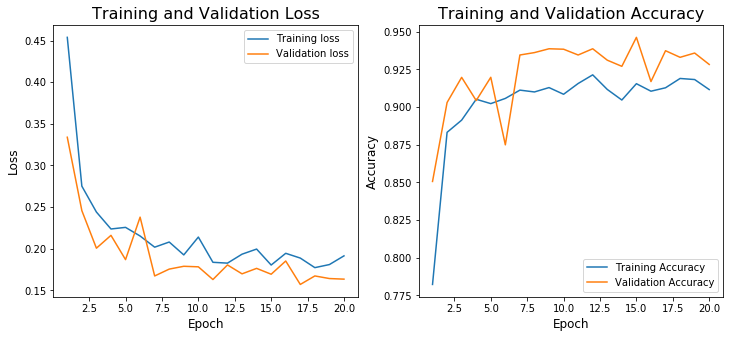

In [90]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epoch_df.Epoch, epoch_df.Train_Loss/1.4, label = 'Training loss')
plt.plot(epoch_df.Epoch, epoch_df.Val_Loss, label = 'Validation loss')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.title('Training and Validation Loss', fontsize=16)

plt.subplot(1,2,2)
plt.plot(epoch_df.Epoch, epoch_df.Train_Accuracy, label = 'Training Accuracy')
plt.plot(epoch_df.Epoch, epoch_df.Val_Accuracy, label = 'Validation Accuracy')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()
plt.title('Training and Validation Accuracy', fontsize=16)

In [91]:
inception_fc2_w = models.inception_v3(pretrained=True)
inception_fc2_w.fc = nn.Sequential(nn.Linear(inception_fc2_w.fc.in_features, 256),
                             nn.ReLU(),
                             nn.Dropout(0.3),
                             nn.Linear(256, 2))
inception_fc2_w.AuxLogits.fc = nn.Sequential(nn.Linear(inception_fc2_w.AuxLogits.fc.in_features, 256),
                                       nn.ReLU(),
                                       nn.Dropout(0.3),
                                       nn.Linear(256, 2))

if device.type == 'cpu':
    state_dict = torch.load('models/Chest_xray_PyTorch_inception_epoch20_lr4_weight_fc2.pth', map_location='cpu')
else:
    state_dict = torch.load('models/Chest_xray_PyTorch_inception_epoch20_lr4_weight_fc2.pth')
inception_fc2_w.load_state_dict(state_dict)
for param in inception_fc2_w.parameters():
    param.requires_grad=False

In [92]:
criterion = nn.CrossEntropyLoss()
summary_df_w, pred_df_w = model_eval(test_loader, inception_fc2_w, criterion, device, classes)

Test Loss: 0.310575

Test Accuracy (Overall): 86.699%  (541.0/624.0)

Test Accuracy of NORMAL: 82.479% (193.0/234.0)
Test Accuracy of PNEUMONIA: 89.231% (348.0/390.0)


In [191]:
# summary_df_w.to_csv('models/Chest_xray_PyTorch_inception_epoch20_lr4_weight_fc2_summary_df.csv', index = False)
# pred_df_w.to_csv('models/Chest_xray_PyTorch_inception_epoch20_lr4_weight_fc2_pred_df.csv', index = False)

In [93]:
cm3_w = confusion_matrix(pred_df_w.true_label, pred_df_w.prediction)

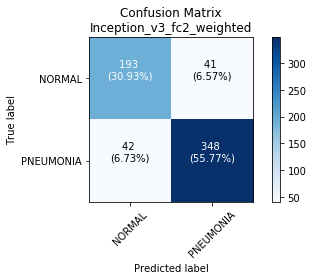

In [106]:
plot_confusion_matrix(cm3_w, classes, title = 'Confusion Matrix\nInception_v3_fc2_weighted')

In [95]:
precision = precision_score(pred_df_w.true_label, pred_df_w.prediction)
recall = recall_score(pred_df_w.true_label, pred_df_w.prediction)
f1 = f1_score(pred_df_w.true_label, pred_df_w.prediction)
print('precision: {:.3f}'.format(precision))
print('recall: {:.3f}'.format(recall))
print('f1 score: {:.3f}'.format(f1))

precision: 0.895
recall: 0.892
f1 score: 0.893


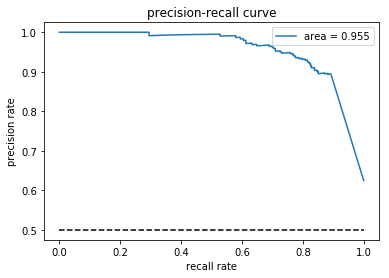

In [96]:
precision, recall, thresholds = precision_recall_curve(pred_df_w.true_label, pred_df_w.prob*pred_df_w.prediction)
# calculate precision-recall AUC
auc_score = auc(recall, precision)

plt.figure(1)
plt.plot([0, 1], [0.5, 0.5], 'k--')
plt.plot(recall, precision, label='area = {:.3f}'.format(auc_score))
plt.xlabel('recall rate')
plt.ylabel('precision rate')
plt.title('precision-recall curve')
plt.legend(loc='best')
plt.show()

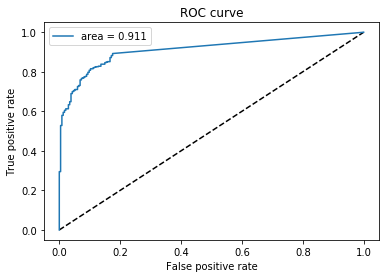

In [97]:
from sklearn.metrics import roc_curve, auc
## probs: probabilities for class 1 only
fpr, tpr, thresholds = roc_curve(pred_df_w.true_label, pred_df_w.prob*pred_df_w.prediction)
auc_value = auc(fpr, tpr)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='area = {:.3f}'.format(auc_value))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

As expected, precision slightly increases in sacrifice of the decrease of the recall. After appplying class weight, our model can achieve an approximately equal precision and recall score around 0.89. However, the overall prediction accuracy and F1 score decrease after adding class weight. Thus, I decide to use the convolutional part (ConvNet) of the pretrained Inception_v3 model plus a trained fully-connected layer with 256 nodes and the trained final classifier as the optimal model.

# 4. Summary of models

Here, let's evaluate the 3 models trained without and with class weight altogether.

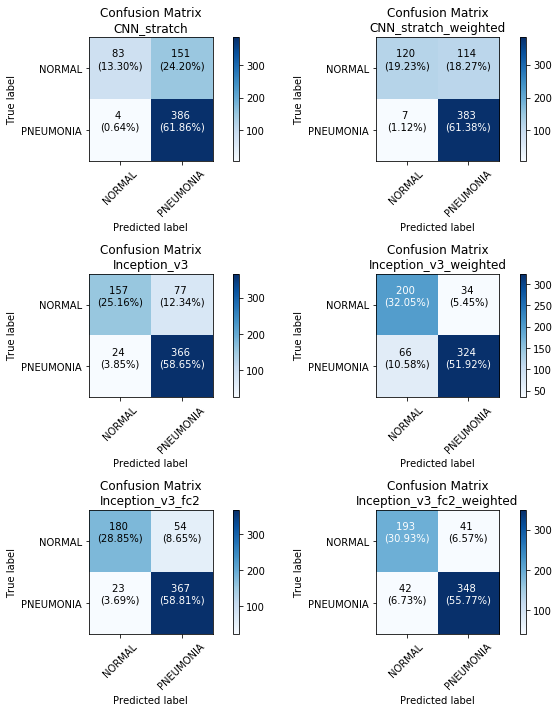

In [107]:
fig = plt.figure(figsize=(10,10))
cm_list = [cm1, cm1_w, cm2, cm2_w, cm3, cm3_w]
cm_title = ['Confusion Matrix\nCNN_stratch', 'Confusion Matrix\nCNN_stratch_weighted', 'Confusion Matrix\nInception_v3', 'Confusion Matrix\nInception_v3_weighted', 'Confusion Matrix\nInception_v3_fc2', 'Confusion Matrix\nInception_v3_fc2_weighted']
for i in np.arange(6):
    ax = fig.add_subplot(3,2,i+1)
    plot_confusion_matrix(cm_list[i], classes, title = cm_title[i])
plt.tight_layout()

In [110]:
## load summary of prediction statistics obtained for each model
summary_df = pd.read_csv('models/Prediction_summary.csv', index_col='Model')
summary_df.T

Model          CNN_scratch  CNN_scratch_w  Inception_v3  Inception_v3_w  \
Accuracy          0.751603       0.806090      0.838141        0.839744   
Normal_acc        0.354701       0.512821      0.670940        0.854701   
Pneumonia_acc     0.989744       0.982051      0.938462        0.830769   
True_pos        386.000000     383.000000    366.000000      324.000000   
True_neg         83.000000     120.000000    157.000000      200.000000   
False_pos       151.000000     114.000000     77.000000       34.000000   
False_neg         4.000000       7.000000     24.000000       66.000000   
Precision         0.718808       0.770624      0.826185        0.905028   
Recall            0.989744       0.982051      0.938462        0.830769   
F1_score          0.832794       0.863585      0.878752        0.866310   
ROC_AUC           0.915000       0.922000      0.912000        0.881000   
PRC_AUC           0.945000       0.948000      0.950000        0.942000   
Total           624.000000     624.000000    624.000000      624.000000   

Model          Inception_v3_fc2  Inception_v3_fc2_w  
Accuracy               0.876603            0.866987  
Normal_acc             0.769231            0.824786  
Pneumonia_acc          0.941026            0.892308  
True_pos             367.000000          348.000000  
True_neg             180.000000          193.000000  
False_pos             54.000000           41.000000  
False_neg             23.000000           42.000000  
Precision              0.871734            0.894602  
Recall                 0.941026            0.892308  
F1_score               0.905055            0.893453  
ROC_AUC                0.929000            0.911000  
PRC_AUC                0.960000            0.955000  
Total                624.000000          624.000000

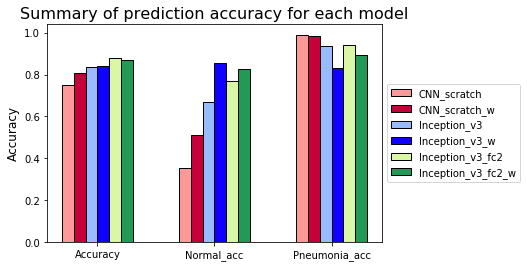

In [117]:
cnn_models = summary_df.index.values
colors = ['#ff9999','#C70039','#99bbff','#1000ff','#DAF7A6','#229954']
metrics = ['Accuracy', 'Normal_acc', 'Pneumonia_acc']
barWidth = 0.10
for i in np.arange(6):
    plt.bar(np.arange(3)+barWidth*i, summary_df.loc[cnn_models[i], metrics], color = colors[i], width=barWidth, edgecolor='black', label=cnn_models[i])
plt.xticks([r + barWidth + 0.15 for r in np.arange(3)], metrics)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Summary of prediction accuracy for each model', fontsize=16)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

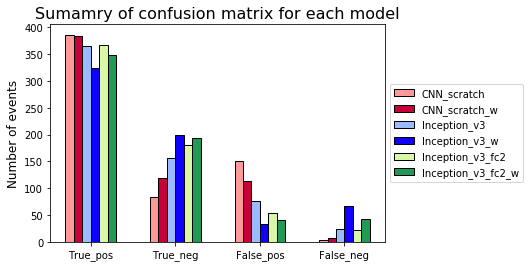

In [118]:
cnn_models = summary_df.index.values
colors = ['#ff9999','#C70039','#99bbff','#1000ff','#DAF7A6','#229954']
metrics = ['True_pos', 'True_neg', 'False_pos', 'False_neg']
barWidth = 0.10
for i in np.arange(6):
    plt.bar(np.arange(4)+barWidth*i, summary_df.loc[cnn_models[i], metrics], color = colors[i], width=barWidth, edgecolor='black', label=cnn_models[i])
plt.xticks([r + barWidth + 0.15 for r in np.arange(4)], metrics)
plt.ylabel('Number of events', fontsize=12)
plt.title('Sumamry of confusion matrix for each model', fontsize=16)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

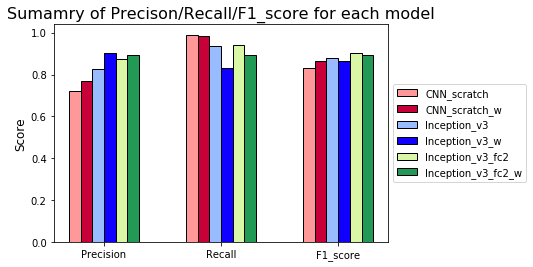

In [119]:
cnn_models = summary_df.index.values
colors = ['#ff9999','#C70039','#99bbff','#1000ff','#DAF7A6','#229954']
metrics = ['Precision', 'Recall', 'F1_score']
barWidth = 0.10
for i in np.arange(6):
    plt.bar(np.arange(3)+barWidth*i, summary_df.loc[cnn_models[i], metrics], color = colors[i], width=barWidth, edgecolor='black', label=cnn_models[i])
plt.xticks([r + barWidth + 0.15 for r in np.arange(3)], metrics)
plt.ylabel('Score', fontsize=12)
plt.title('Sumamry of Precison/Recall/F1_score for each model', fontsize=16)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

Based on the evaluation metrics plotted above, Inception_v3_fc2 (Inception_v3(conv_pretrained) + fully-connected layer(256 nodes) + final classifier) achieves the optimal prediction performance by achieving high prediction accuracy, precision, recall, F1 scores and keep a good balance between false positive and false negative rate. 

### Visualize images and the classification result

In [120]:
pred_df = pd.read_csv('models/Chest_xray_PyTorch_inception_epoch20_lr4_fc2_pred_df.csv', index_col = 'file_path')
pred_df.head()

true_label  prediction  \
file_path                                                                    
/Volumes/Yuchen_Drive/Chest_xray/test/PNEUMONIA...           1           1   
/Volumes/Yuchen_Drive/Chest_xray/test/PNEUMONIA...           1           1   
/Volumes/Yuchen_Drive/Chest_xray/test/PNEUMONIA...           1           1   
/Volumes/Yuchen_Drive/Chest_xray/test/NORMAL/NO...           0           0   
/Volumes/Yuchen_Drive/Chest_xray/test/PNEUMONIA...           1           1   

                                                        prob    NORMAL  \
file_path                                                                
/Volumes/Yuchen_Drive/Chest_xray/test/PNEUMONIA...  0.936817  0.063183   
/Volumes/Yuchen_Drive/Chest_xray/test/PNEUMONIA...  0.615064  0.384936   
/Volumes/Yuchen_Drive/Chest_xray/test/PNEUMONIA...  0.956973  0.043027   
/Volumes/Yuchen_Drive/Chest_xray/test/NORMAL/NO...  0.879405  0.879405   
/Volumes/Yuchen_Drive/Chest_xray/test/PNEUMONIA...  0.908451  0.091549   

                                                    PNEUMONIA  
file_path                                                      
/Volumes/Yuchen_Drive/Chest_xray/test/PNEUMONIA...   0.936817  
/Volumes/Yuchen_Drive/Chest_xray/test/PNEUMONIA...   0.615064  
/Volumes/Yuchen_Drive/Chest_xray/test/PNEUMONIA...   0.956973  
/Volumes/Yuchen_Drive/Chest_xray/test/NORMAL/NO...   0.120595  
/Volumes/Yuchen_Drive/Chest_xray/test/PNEUMONIA...   0.908451

In [121]:
pred_true_pos = pred_df[(pred_df.true_label == 1) & (pred_df.prediction == 1)]   ## 362
pred_true_neg = pred_df[(pred_df.true_label == 0) & (pred_df.prediction == 0)]   ## 168
pred_false_pos = pred_df[(pred_df.true_label == 0) & (pred_df.prediction == 1)]   ## 66
pred_false_neg = pred_df[(pred_df.true_label == 1) & (pred_df.prediction == 0)]   ## 28

Text(0.5, 0.98, 'False negative images (label:PNEUMONIA/pred:NORMAL)')

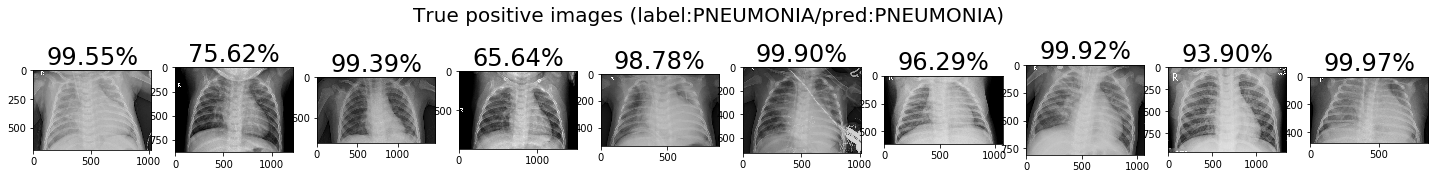

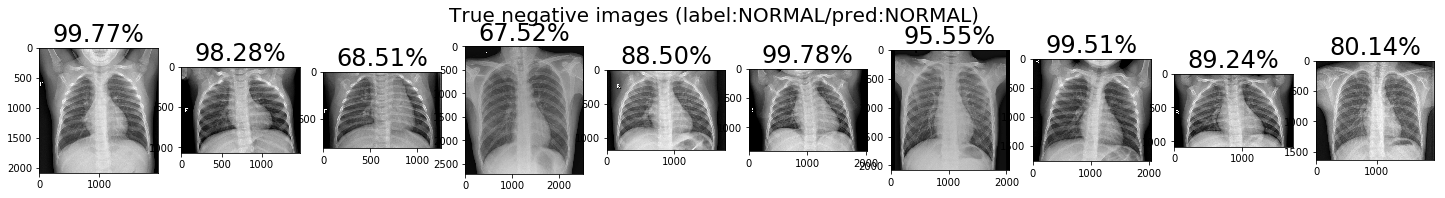

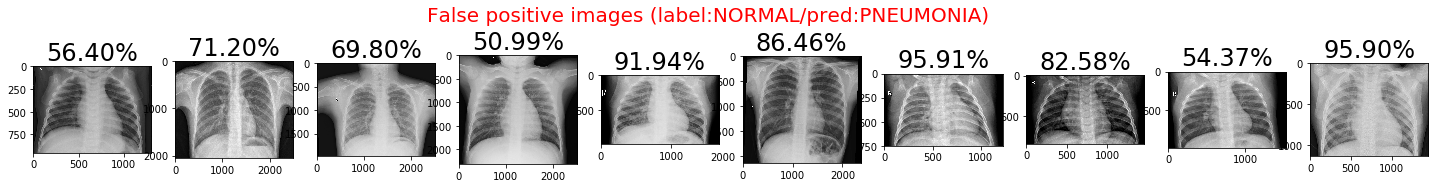

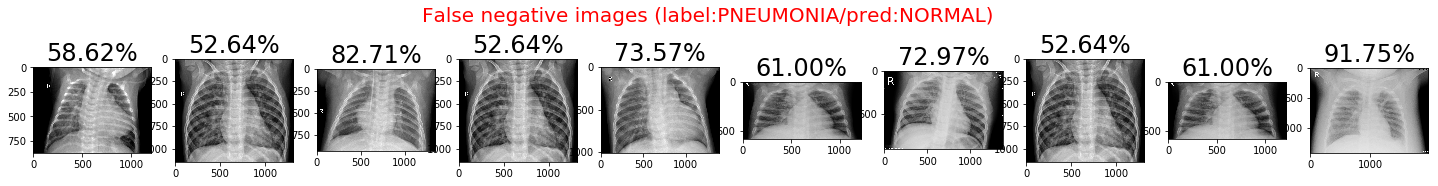

In [122]:
fig = plt.figure(figsize=(25,3))
for i,img_path in enumerate(np.random.choice(pred_true_pos.index, 10)):
    ax = fig.add_subplot(1,10,i+1)
    ax.imshow(cv2.imread(img_path)[:,:,0], cmap = 'gray')
    prob = pred_df.loc[img_path,].prob
    ax.set_title('{:.2f}%'.format(prob*100), fontsize=24)
fig.suptitle('True positive images (label:PNEUMONIA/pred:PNEUMONIA)', fontsize = 20)

fig = plt.figure(figsize=(25,3))
for i,img_path in enumerate(np.random.choice(pred_true_neg.index, 10)):
    ax = fig.add_subplot(1,10,i+1)
    ax.imshow(cv2.imread(img_path)[:,:,0], cmap = 'gray')
    prob = pred_df.loc[img_path,].prob
    ax.set_title('{:.2f}%'.format(prob*100), fontsize=24)
fig.suptitle('True negative images (label:NORMAL/pred:NORMAL)', fontsize = 20)

fig = plt.figure(figsize=(25,3))
for i,img_path in enumerate(np.random.choice(pred_false_pos.index, 10)):
    ax = fig.add_subplot(1,10,i+1)
    ax.imshow(cv2.imread(img_path)[:,:,0], cmap = 'gray')
    prob = pred_df.loc[img_path,].prob
    ax.set_title('{:.2f}%'.format(prob*100), fontsize=24)
fig.suptitle('False positive images (label:NORMAL/pred:PNEUMONIA)', fontsize = 20, color = 'red')

fig = plt.figure(figsize=(25,3))
for i,img_path in enumerate(np.random.choice(pred_false_neg.index, 10)):
    ax = fig.add_subplot(1,10,i+1)
    ax.imshow(cv2.imread(img_path)[:,:,0], cmap = 'gray')
    prob = pred_df.loc[img_path,].prob
    ax.set_title('{:.2f}%'.format(prob*100), fontsize=24)
fig.suptitle('False negative images (label:PNEUMONIA/pred:NORMAL)', fontsize = 20, color = 'red')

# 5. CNN visualization

## 5.1 t-SNE plots to view features extracted by Inception_V3

In [199]:
def feature_extraction(test_loader, model, device, classes, n_feature):
    dt = np.dtype(int)
    true_label = np.array([], dtype = dt)
    path_array = np.array([])
    feature_array = np.array(['idx'+str(i)for i in np.arange(n_feature)]).reshape(1,n_feature)
  
    model = model.to(device)
    with torch.no_grad():
        model.eval()
        for images, labels, paths in test_loader:
            path_array = np.append(path_array, np.array(paths))
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            
            if device.type == 'cpu':
                true_label = np.append(true_label, labels)
                feature_array = np.concatenate((feature_array, output))
      
            else:
                true_label = np.append(true_label, labels.cpu())
                feature_array = np.concatenate((feature_array, output.cpu()))
                
    feature_df = pd.DataFrame(feature_array[1:], columns = feature_array[0], index = path_array)
    feature_df['label'] = true_label
    return feature_df

In [198]:
inception_fc2 = models.inception_v3(pretrained=True)
inception_fc2.fc = nn.Sequential(nn.Linear(inception_fc2.fc.in_features, 256),
                             nn.ReLU(),
                             nn.Dropout(0.3),
                             nn.Linear(256, 2))
inception_fc2.AuxLogits.fc = nn.Sequential(nn.Linear(inception_fc2.AuxLogits.fc.in_features, 256),
                                       nn.ReLU(),
                                       nn.Dropout(0.3),
                                       nn.Linear(256, 2))

if device.type == 'cpu':
    state_dict = torch.load('models/Chest_xray_PyTorch_inception_epoch20_lr4_fc2.pth', map_location='cpu')
else:
    state_dict = torch.load('models/Chest_xray_PyTorch_inception_epoch20_lr4_fc2.pth')
inception_fc2.load_state_dict(state_dict)
for param in inception_fc2.parameters():
    param.requires_grad=False

In [200]:
new_classifier = nn.Sequential(*list(inception_fc2.fc.children())[:-3])
inception_fc2.fc = new_classifier

In [201]:
img_transforms = transforms.Compose([
    transforms.Resize((299,299)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_data = ImageFolderWithPaths(train_path, transform = img_transforms)
train_loader = torch.utils.data.DataLoader(train_data, batch_size = BATCH_SIZE, shuffle = True)

test_data = ImageFolderWithPaths(test_path, transform = img_transforms)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = BATCH_SIZE, shuffle = True)

In [202]:
inception_fc2_feature_train_df = feature_extraction(train_loader, inception_fc2, device, classes, 256)
inception_fc2_feature_test_df = feature_extraction(test_loader, inception_fc2, device, classes, 256)

In [30]:
# inception_fc2_feature_train_df.to_csv('models/Chest_xray_PyTorch_inception_epoch20_lr4_fc2_feature_train_df.csv', index = False)
# inception_fc2_feature_test_df.to_csv('models/Chest_xray_PyTorch_inception_epoch20_lr4_fc2_feature_test_df.csv', index = False)
inception_fc2_feature_train_df = pd.read_csv('models/Chest_xray_PyTorch_inception_epoch20_lr4_fc2_feature_train_df.csv')
inception_fc2_feature_test_df = pd.read_csv('models/Chest_xray_PyTorch_inception_epoch20_lr4_fc2_feature_test_df.csv')

In [31]:
def feature_tsne_plot(feature_df, classes, title='t-SNE plot'):
    label_to_id_dict = {v:i for i,v in enumerate(classes)}
    id_to_label_dict = {v: k for k, v in label_to_id_dict.items()}
    feature_df['class_label'] = feature_df.label.map(id_to_label_dict)
    data = feature_df.iloc[:,:-2]
    data = np.reshape(data, (data.shape[0], -1)).astype(np.float64)
    data_2d = bh_sne(data)
    df_subset = pd.DataFrame({'tsne-2d-one':data_2d[:,0], 'tsne-2d-two':data_2d[:,1], 'target':feature_df.class_label})
    plt.figure(figsize=(8,8))
    tsne = sns.scatterplot(
        x="tsne-2d-one", y="tsne-2d-two",
        hue="target",
        hue_order=classes,
        palette=sns.color_palette("hls", len(classes)),
        data=df_subset,
        legend="full",
        alpha=1)
    plt.title(title, fontsize=16)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show(tsne)

In [33]:
classes = ['NORMAL', 'PNEUNOMIA']

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


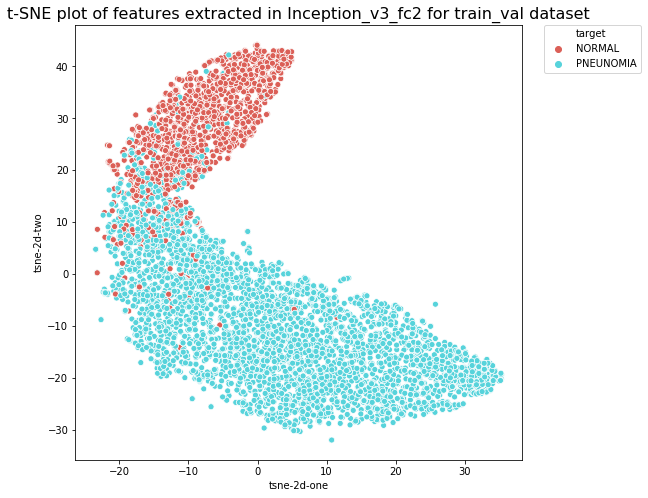

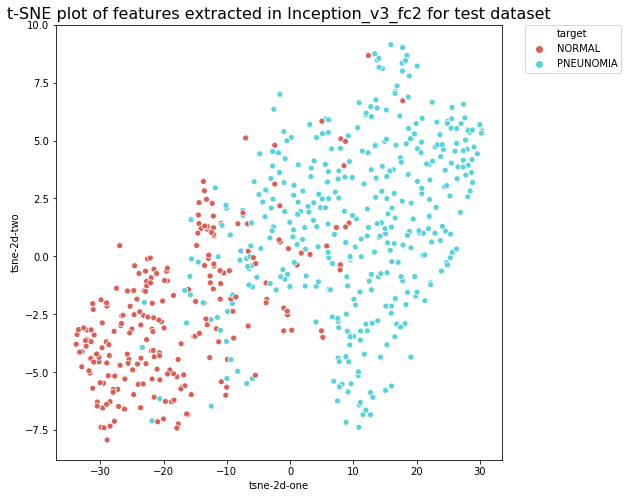

In [36]:
feature_tsne_plot(shuffle(inception_fc2_feature_train_df), classes, title = 't-SNE plot of features extracted in Inception_v3_fc2 for train_val dataset')
feature_tsne_plot(shuffle(inception_fc2_feature_test_df), classes, title = 't-SNE plot of features extracted in Inception_v3_fc2 for test dataset')

## 5.2 View output of the CNN layers

In [127]:
def im_convert(tensor):
    """ Display a tensor as an image. """
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

Text(0.5, 1.0, 'Raw H&E image')

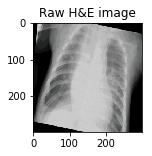

In [135]:
images, labels = next(iter(train_loader))
img = images[0].unsqueeze(0)
plt.figure(figsize=(2,2))
plt.imshow(im_convert(img))
plt.title('Raw H&E image')

In [130]:
def viz_layer(layer, n_filters= 32, title = 'output of CNN'):
    fig = plt.figure(figsize=(20, n_filters/4))
    
    for i in range(n_filters):
        ax = fig.add_subplot(n_filters/8, 8, i+1, xticks=[], yticks=[])
        # grab layer outputs
        ax.imshow(np.squeeze(layer[0,i].data.numpy()), cmap = 'gray')
        ax.set_title('Output %s' % str(i+1))
    fig.suptitle(title, fontsize=20)

In [131]:
inception_layers = list(inception._modules.keys())

BasicConv2d(
  (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
)


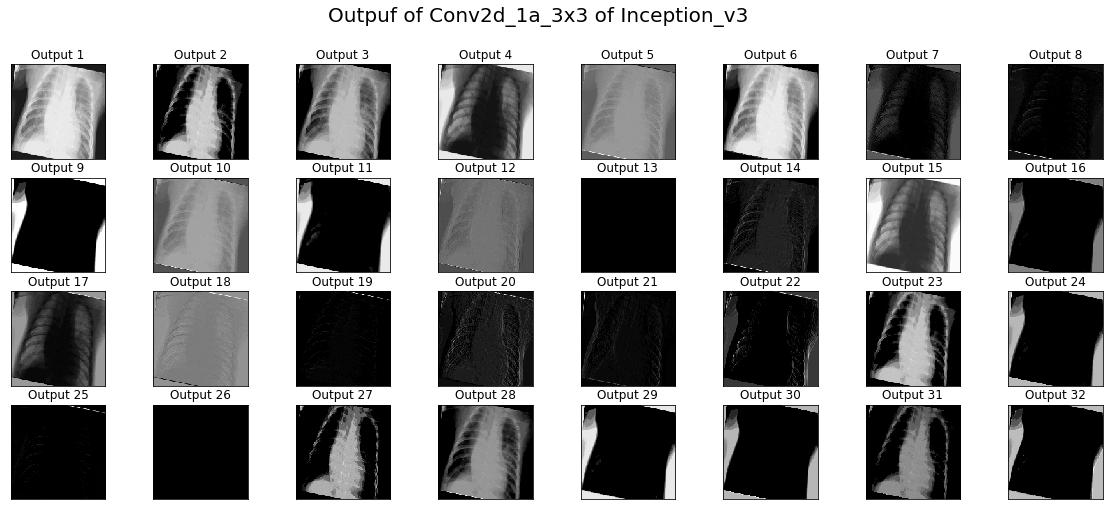

In [132]:
layer1 = inception._modules[inception_layers[0]]
print(layer1)
img_layer1 = layer1(img)
viz_layer(img_layer1, n_filters=32, title = 'Outpuf of {} of Inception_v3'.format(inception_layers[0]))

BasicConv2d(
  (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
)


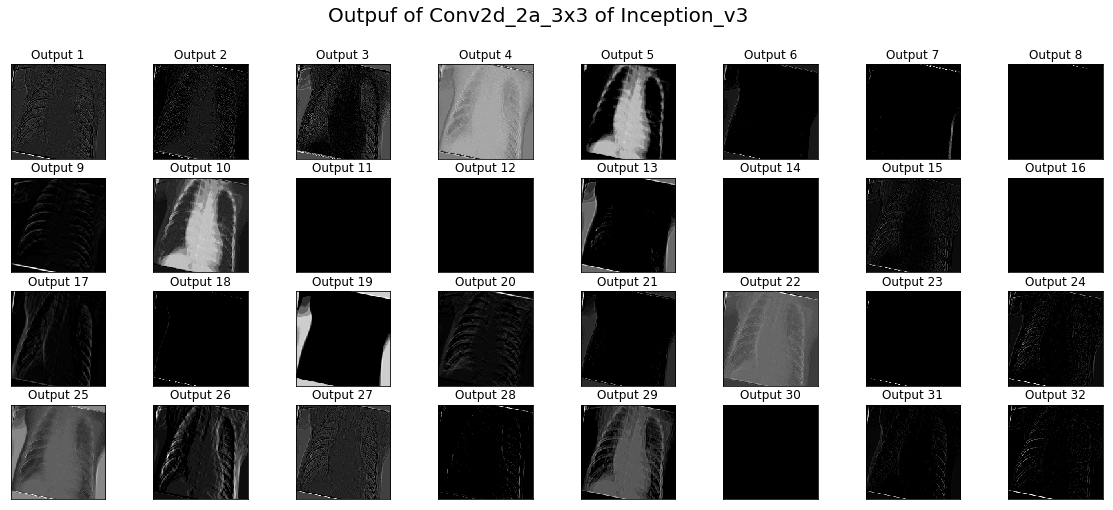

In [133]:
layer2 = inception._modules[inception_layers[1]]
print(layer2)
img_layer2 = layer2(layer1(img))
viz_layer(img_layer2, n_filters=32, title = 'Outpuf of {} of Inception_v3'.format(inception_layers[1]))

BasicConv2d(
  (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
)


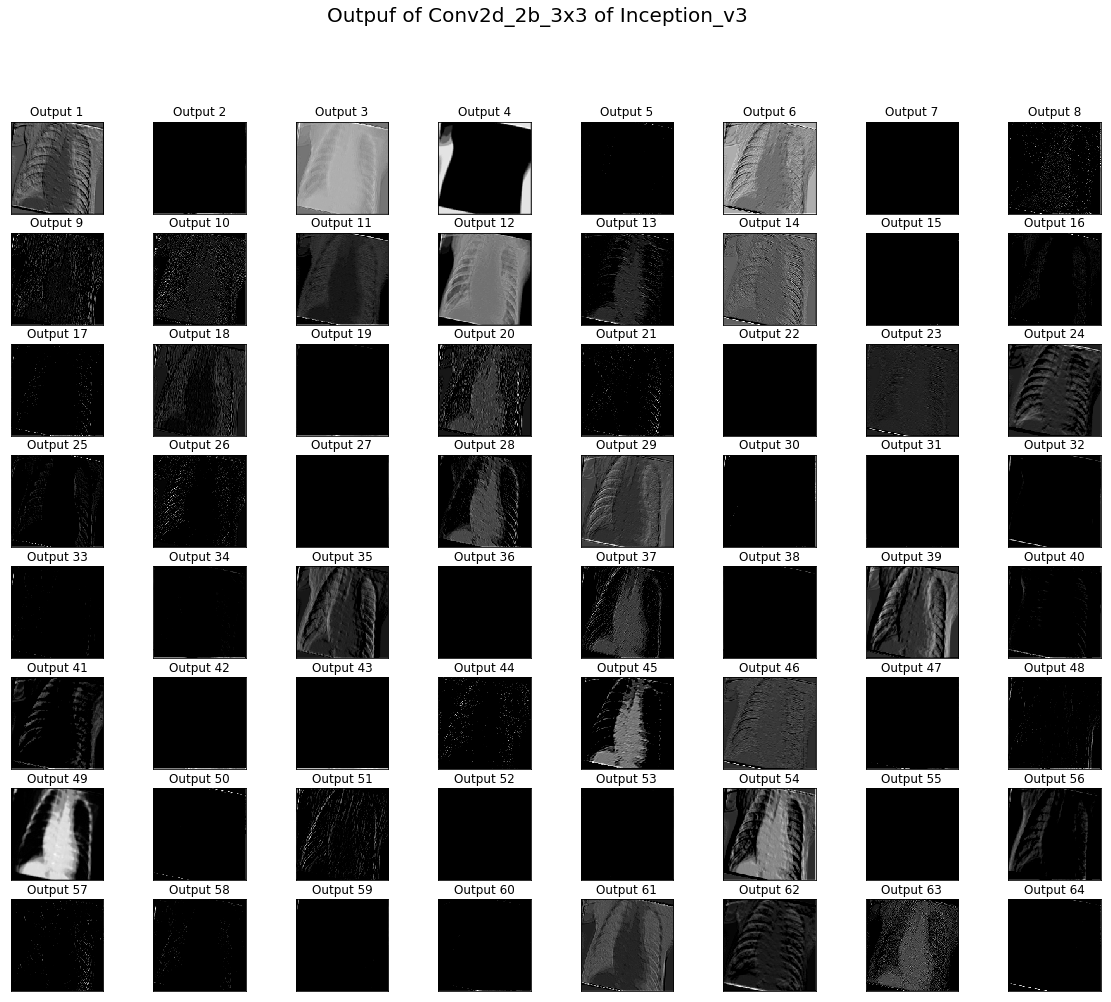

In [134]:
layer3 = inception._modules[inception_layers[2]]
print(layer3)
img_layer3 = layer3(layer2(layer1(img)))
viz_layer(img_layer3, n_filters=64, title = 'Outpuf of {} of Inception_v3'.format(inception_layers[2]))

# 6. Conclusion and discussion

**Conclusion**:
Using pretrained Inception_v3 (convolutional part), adding and training a fully-connected layer with 256 nodes and training the final classifier for chest X-Ray images in this dataset can achieve:
   * Overall prediction accuracy: 0.877
   * Precision: 0.872
   * Recall: 0.941
   * F1 score: 0.905
   * ROC_AUC: 0.929

1.To perform binary classification of Chest X-Ray images into `NORMAL` and `PNEUMONIA` classes, I used convolutional neural networks. Three models have been used:
   * A 14-layer CNN model built from scratch (((ConV-ReLU)x3-MaxPool)x3 --flattening-- FC1-ReLU-FC2)
   * Transfer learning using pre-trained Inception_v3 and train the final classifier
   * Transfer learning using pre-trained Inception_v3, adding a fully-connected layer with 256 nodes before the classifier, and train both the fully-connected layer and the final classifier

    The major challenge of this project is how to improve the prediction accuracy of the `NORMAL` class, decrease false positive rate and increase precision score. At the same time, we have to avoid sacrificing prediction accuracy of the `PNEUMONIA` class and the recall score considering the 'inverse' relationship between these evaluation metrics.


2.Adding class_weight to the training model could largely increase the precision score in both the scratch CNN model and the Inception_v3. However, the prediction recall decreases to certain extent.


3.For binary classificatin problems, it's very important to choose the correct evaluation metrics. In this project, I computed statistics for overal prediction accuracy, accuracy for `NORMAL` and `PNEUMONIA` classes, confusion matrix, precision, recall, F1 score, AUC for ROC curve and AUC for PRC curve. Using these metrics in combination could provide a better understanding of the prediction performance and provide insight into strategies of how to improve the model.


4.One hypothesis of the low precision score is due to the imbalanced dataset since the NORMAL/PNEUMONIA ratio is around 1:3 in training dataset. This hypothesis is partially demonstrated by the fact that adding class weight could significantly increase the precision. For future direction, it's important to keep the class ratio in the training dataset to achieve better prediction performance. One strategy is to collect more images for the underrepresented group. Considering the large number of X-Ray images used for medical diagnosis, the dataset size can be easily enlarged.


5.In addition to the training model, it's also important to consider the real application of this classification strategy in medical diagnosis. In real medical diagnosis of pneumonia, additional tests such as blood test, pulse oximetry, and sputum test will be included. Doctors will also ask about medical history and do physical exams such as listening to lungs with a stethoscope to help make a final diagnosis. Thus, it's helpful to combine the CNN classification of X-Ray images with other test measurement and apply additional machine learning models to further improve prediction accuracy. We also need to consider the risk of 'false positive' and 'false negative' diagnosis to achieve the optimal prediction performance.